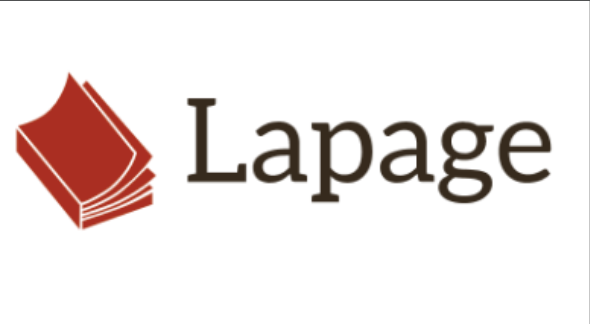

### Résumé de la demande

La librairie Lapage souhaite analyser ses **2 premières années d'activité commerciales en ligne.**

Cette analyse se définie en 3 parties :
- Un nettoyage et formatage des données
- Une analyse exploratoire des données (demandé par Antoine)
- Une analyse plus ciblée sur le client (demandé par Julie)

# Sommaire

* [Partie 1 : Nettoyage des données](#chapter1)
    * [1.1 : Jointure des tables : Création de la table support d'analyse "all_data"](#section_1_1)
        * [1.1.1 : id_prod non référencé dans la liste des produits](#section_1_1_1)
    * [1.2 : Gestion de la variable "Birth"](#section_1_2)
    * [1.3 : Gestion de la variable "date"](#section_1_3)
        * [1.3.1 : Présence de données test](#section_1_3_1)
        * [1.3.2 : Formatage de la colonne "date"](#section_1_3_2)
    
    
* [Partie 2 : Analyse exploratoire des données](#chapter2)
    * [2.1 : Evolution du Chiffre d'Affaires](#section_2_1)
        * [2.1.1 : CA par année](#section_2_1_1)
        * [2.1.2 : CA par mois](#section_2_1_2)
        * [2.1.3 : CA par catégorie](#section_2_1_3)
        * [2.1.4 : CA par âge](#section_2_1_4)
        * [2.1.5 : CA par genre](#section_2_1_5)
    * [2.2 : La moyenne mobile](#section_2_2)
    * [2.3 : Les tops et les flops des livres](#section_2_3)


* [Partie 3 : Tests statistiques](#chapter3)
    * [3.1 : La relation entre les ventes par catégories et le genre](#section_3_1)
    * [3.2 : La corrélation entre l'age et le Chiffre d'Affaires](#section_3_2)
    * [3.3 : La relation entre l'âge et la fréquence d'achat](#section_3_3)
    * [3.4 : L'age par rapport au panier moyen](#section_3_4)
    * [3.5 : La catégorie de livre acheté par rapport à l'age](#section_3_5)
    

In [1]:
# Import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# Suppression des alertes
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Import des données à disposition
client = pd.read_csv(r"C:\Users\Del FanFan\projects\project_6\Livrables\data\customers.csv")
livre = pd.read_csv(r"C:\Users\Del FanFan\projects\project_6\Livrables\data\products.csv")
transaction = pd.read_csv(r"C:\Users\Del FanFan\projects\project_6\Livrables\data\transactions.csv")

# Partie 1 : Préparation & Nettoyage des données <a class="anchor" id="chapter1"></a>

In [3]:
print(client.nunique())
print(livre.nunique())
print(transaction.nunique())

client_id    8623
sex             2
birth          76
dtype: int64
id_prod    3287
price      1455
categ         3
dtype: int64
id_prod         3267
date          679371
session_id    342316
client_id       8602
dtype: int64


### <ins>Observations</ins>  
Pour analyser l'activité commerciale de notre client, nous avons à disposition 3 tables de données  
 * La table <ins>client</ins> : (Dimensions : 8623 lignes * 3 colonnes)  
> - **client_id** : L'identification unique du client (*object*)  
> - **sex** : Le genre du client (*object*)  
> - **birth** : L'année de naissance du client (*int*)  
        
 * La table <ins>livre</ins> : (Dimensions : 3287 lignes * 3 colonnes)  
> - **id_prod** : L'identification unique du livre (*object*)  
> - **price** : Le prix du livre en euros (*float*)
> - **categ** : La catégorie du livre (*int*)  
        
 * La table <ins>transaction</ins> : (Dimensions : 679532 * 4 colonnes)  
> - **id_prod** : L'identification unique du livre (*object*)  
> - **date** : L'heure et la date de la transaction (*object*)  
> - **client_id** : L'identification unique du client (*object*)  
> - **session_id** : La session de connexion du client (*object*)  

Ces 2 dernières années, la librairie a eu **8623** clients qui ont réalisé en tout **679532** transactions sur son site marchand.

Le site propose 3287 articles répartis en 3 catgérories de livre.

Nous allons à présent fusionner ces 3 tables afin de poursuivre l'analyse.


## 1.1 : Jointure des tables : Création de la table support d'analyse "all_data" <a class="anchor" id="section_1_1"></a>

Nous allons créer la table all_data qui sera la jointure des 3 tables. Avant cela, nous allons observer les joitures suivantes :  
>transaction / client  
>transaction / livre  

Ensuite, nous allons  :
- Faire une 1ère jointure entre les tables *transaction* et *client* (intermédiaire)   
- Faire une seconde jointure entre la 1ère jointure et la table *livre* (all_data)

Nous allons analyser chaque étapes au fur et à mesure.

### <ins>jointure</ins> (transaction - client) 

In [4]:
trans_client = transaction.merge(client, how="outer", on="client_id", indicator=True)
print("valeurs uniques du tableau :\n",trans_client.nunique(),"\n")
print("Dimensions du tableau :",trans_client.shape)

valeurs uniques du tableau :
 id_prod         3267
date          679371
session_id    342316
client_id       8623
sex                2
birth             76
_merge             2
dtype: int64 

Dimensions du tableau : (679553, 7)


In [5]:
# Liste des 21 clients inscrits sur le site n'ayant pas réalisé d'achats 
trans_client[trans_client["_merge"]!='both'].head()

,id_prod,date,session_id,client_id,sex,birth,_merge
679532,NaN,NaN,NaN,c_8253,f,2001,right_only
679533,NaN,NaN,NaN,c_3789,f,1997,right_only
679534,NaN,NaN,NaN,c_4406,f,1998,right_only
679535,NaN,NaN,NaN,c_2706,f,1967,right_only
679536,NaN,NaN,NaN,c_3443,m,1959,right_only


<ins>Observations</ins>  

La 1ère jointure entre *transaction* et *client* nous permet d'observer :  
- Sur 8623 clients inscrits sur le site, 21 n'ont pas fais d'achat.  

### <ins>jointure</ins> (transaction - livre) 

In [6]:
trans_livre = transaction.merge(livre, how="outer", on="id_prod", indicator=True)
print("valeurs uniques du tableau :\n",trans_livre.nunique(),"\n")
print("Dimensions du tableau :",trans_livre.shape)

valeurs uniques du tableau :
 id_prod         3288
date          679371
session_id    342316
client_id       8602
price           1455
categ              3
_merge             3
dtype: int64 

Dimensions du tableau : (679553, 7)


In [7]:
# Liste des 21 livres n'ayant réalisé aucune vente
trans_livre[trans_livre["_merge"]=='right_only']

,id_prod,date,session_id,client_id,price,categ,_merge
679532,0_1016,NaN,NaN,NaN,35.06,0.0,right_only
679533,0_1780,NaN,NaN,NaN,1.67,0.0,right_only
679534,0_1062,NaN,NaN,NaN,20.08,0.0,right_only
679535,0_1119,NaN,NaN,NaN,2.99,0.0,right_only
679536,0_1014,NaN,NaN,NaN,1.15,0.0,right_only
679537,1_0,NaN,NaN,NaN,31.82,1.0,right_only
679538,0_1318,NaN,NaN,NaN,20.92,0.0,right_only
679539,0_1800,NaN,NaN,NaN,22.05,0.0,right_only
679540,0_1645,NaN,NaN,NaN,2.99,0.0,right_only
679541,0_322,NaN,NaN,NaN,2.99,0.0,right_only


### <ins>Observations</ins>  

La jointure entre *transaction* et *livre* nous permet d'observer :  
- Sur 3287 livres référencés sur le site, 21 n'ont pas réalisés de vente.  

In [8]:
# Données non jointe de gauche
trans_livre[trans_livre["_merge"]=='left_only'].head()

,id_prod,date,session_id,client_id,price,categ,_merge
542560,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,NaN,NaN,left_only
542561,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,NaN,NaN,left_only
542562,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,NaN,NaN,left_only
542563,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,NaN,NaN,left_only
542564,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,NaN,NaN,left_only


In [9]:
# Comptage des valeurs uniques
trans_livre[trans_livre["_merge"]=='left_only'].nunique()

id_prod         1
date          221
session_id    221
client_id     100
price           0
categ           0
_merge          1
dtype: int64

### <ins>Observations</ins>  
Nous constatons que les transactions ayant comme **id_prod : 0_2245** ne présentent pas de prix ni de catégorie. De plus, cet id_prod n'est pas référencé parmis la table des livres....

Plusieurs pistes à exploiter :
- Remboursement ?
- Abonnement ?
- Location ?
- Bon promotionnel ?

### <ins>Conclusion</ins>  
Les différentes jointures nous ont permis d'observer plusieurs points :
- 21 clients inscrits sur le site n'ont pas réalisé d'achat  
- 20 livres parmi les références disponibles n'ont fait de vente
- 221 transactions comportants le même "id_prod" mais n'ayant pas de prix indiqué

Pour la suite de l'analyse, nous ne les prendrons pas en compte, et ferons une jointure interne sur toute les tables afin de créer la table <ins>**all_data**</ins>.

In [10]:
### Jointure intermédiare des tables "transaction" et "client"
intermediaire = transaction.merge(client, how="inner", on="client_id")

# Jointure finale, création de la table all_data
all_data = intermediaire.merge(livre, how="inner", on="id_prod")

all_data.shape

(679311, 8)

In [11]:
all_data.nunique()

id_prod         3266
date          679150
session_id    342276
client_id       8602
sex                2
birth             76
price           1443
categ              3
dtype: int64

### <ins>Observations</ins>  

A la suite de la joiture des 3 tables, nous obtenons un tableau sans les 3 point cités plus haut (conclusion ci-dessus) 

## 1.2 : Gestion de la variable "birth" <a class="anchor" id="section_1_2"></a>

In [12]:
all_data.birth.unique()

array([1986, 1968, 1985, 1982, 1973, 1980, 1976, 1983, 1984, 1969, 1974,
       1979, 1975, 1988, 1987, 1952, 1990, 1957, 1978, 1981, 1964, 1971,
       1991, 1989, 1956, 1955, 1972, 1965, 1962, 1970, 1977, 1946, 1938,
       1958, 1940, 1960, 1997, 1995, 1953, 1966, 1935, 1967, 2003, 1998,
       1961, 1963, 1948, 2002, 2001, 2000, 1993, 2004, 1942, 1936, 1951,
       1950, 1959, 1943, 1992, 1947, 1996, 1934, 1933, 1945, 1949, 1954,
       1944, 1994, 1999, 1941, 1932, 1937, 1929, 1939, 1930, 1931],
      dtype=int64)

Parmi les années de naissance des clients, figurent des années pouvant être considérées comme des outliers

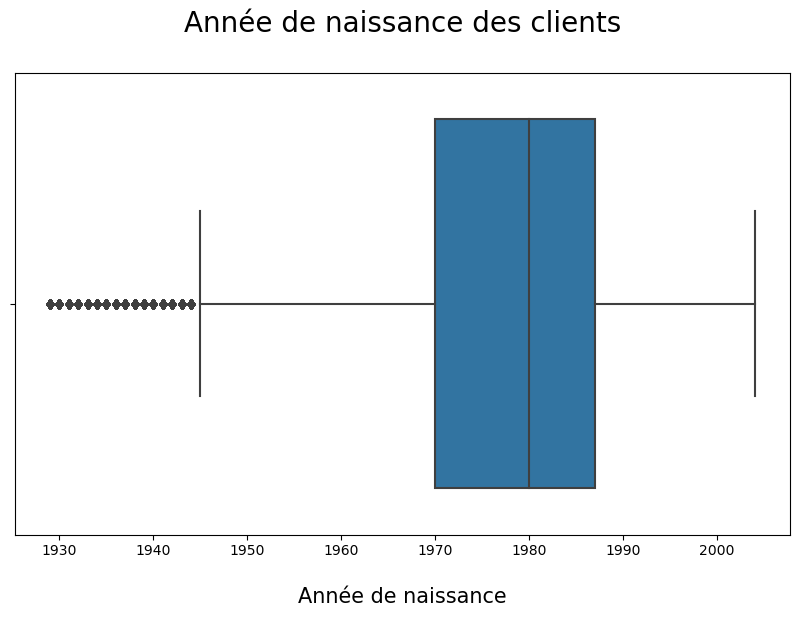

In [13]:
plt.figure(figsize=(10,6))
sns.boxplot(x=all_data["birth"])
plt.xlabel("\n""Année de naissance", fontsize=15)
plt.xticks(fontsize=10)
plt.title("Année de naissance des clients""\n", fontsize=20)
plt.show()

In [14]:
# Calcul du z-score de la variable birth
all_data["z_score"] = (all_data["birth"] - all_data["birth"].mean()) / all_data["birth"].std() 

# Création d'une table contenant les potentiels outliers
outlier_birth = all_data[all_data["z_score"].abs()>3]

outlier_birth.sort_values("birth")

,id_prod,date,session_id,client_id,sex,birth,price,categ,z_score
35026,1_370,2021-09-01 09:48:58.647319,s_83514,c_577,m,1929,13.11,1,-3.595058
29482,0_1453,2022-05-29 09:18:19.870335,s_215761,c_577,m,1929,7.99,0,-3.595058
429978,0_1593,2021-05-28 07:15:31.545130,s_40604,c_5302,m,1929,6.99,0,-3.595058
124513,0_1004,2022-04-06 11:18:29.101631,s_190036,c_577,m,1929,8.07,0,-3.595058
537373,0_2096,2021-11-26 07:22:43.209868,s_125219,c_577,m,1929,14.84,0,-3.595058
...,...,...,...,...,...,...,...,...,...
528313,0_1309,2022-01-18 11:34:08.588122,s_151625,c_878,m,1937,18.99,0,-3.005921
528314,0_1309,2022-09-18 11:34:08.588122,s_269874,c_878,m,1937,18.99,0,-3.005921
132190,1_635,2021-10-01 03:35:01.883210,s_98249,c_6000,f,1937,26.99,1,-3.005921
526194,1_541,2021-10-01 16:56:41.388951,s_98513,c_2377,f,1937,13.99,1,-3.005921


In [15]:
outlier_birth.birth.unique()

array([1935, 1936, 1934, 1933, 1932, 1937, 1929, 1930, 1931], dtype=int64)

### <ins>Observations</ins>
Via la méthode du z-score, nous avons pu déterminer des années de naissance considérées comme outlier. Il s'agit d'année de naissance allant de 1929 à 1937.

Cependant, nous ne les retirerons pas car celà n'a pas été demandé. De plus ces outliers représentent 0.55% des transactions effectuées. Donc pour notre situation, nous les conserverons.

In [16]:
# Suppression de colonne inutile
del all_data["z_score"]

## 1.3 : Gestion de la variable "date" <a class="anchor" id="section_1_3"></a>

In [17]:
# Suppression des nanos-secondes
all_data["date"] = all_data["date"].str[:-7]

### 1.3.1 : Présence de données test <a class="anchor" id="section_1_3_1"></a>

In [18]:
all_data.date.value_counts()

test_2021-03-01 02:30:02    200
2022-09-28 22:32:33           3
2022-12-22 12:54:05           3
2021-11-09 14:05:59           3
2022-08-09 14:05:59           3
                           ... 
2023-01-09 04:22:56           1
2022-02-09 04:22:56           1
2022-02-03 14:40:19           1
2021-09-21 16:12:05           1
2021-03-08 21:10:32           1
Name: date, Length: 675460, dtype: int64

In [19]:
all_data[all_data["date"]=="test_2021-03-01 02:30:02"]

,id_prod,date,session_id,client_id,sex,birth,price,categ
678494,T_0,test_2021-03-01 02:30:02,s_0,ct_0,f,2001,-1.0,0
678495,T_0,test_2021-03-01 02:30:02,s_0,ct_0,f,2001,-1.0,0
678496,T_0,test_2021-03-01 02:30:02,s_0,ct_0,f,2001,-1.0,0
678497,T_0,test_2021-03-01 02:30:02,s_0,ct_0,f,2001,-1.0,0
678498,T_0,test_2021-03-01 02:30:02,s_0,ct_0,f,2001,-1.0,0
...,...,...,...,...,...,...,...,...
678689,T_0,test_2021-03-01 02:30:02,s_0,ct_1,m,2001,-1.0,0
678690,T_0,test_2021-03-01 02:30:02,s_0,ct_1,m,2001,-1.0,0
678691,T_0,test_2021-03-01 02:30:02,s_0,ct_1,m,2001,-1.0,0
678692,T_0,test_2021-03-01 02:30:02,s_0,ct_1,m,2001,-1.0,0


<ins>Observations</ins>  
Oublie de données test. Communiquer aux data engeniering

In [20]:
# Retrait des tuples test du jeu de données
all_data = all_data[all_data["date"]!="test_2021-03-01 02:30:02"]

In [21]:
# Conversion de la colonne date au format date
all_data["date"] = pd.to_datetime(all_data["date"], format="%Y/%m/%d %H:%M:%S")

In [22]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679310
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  datetime64[ns]
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   sex         679111 non-null  object        
 5   birth       679111 non-null  int64         
 6   price       679111 non-null  float64       
 7   categ       679111 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 46.6+ MB


### <ins>*Conclusion*</ins>

Notre base de données **all_data** est à présent nettoyées et formatées. Nous pouvons dès lors, passer à l'analyse exploratoire de notre dataset.

# Partie 2 : Analyse exploratoire des données <a class="anchor" id="chapter2"></a>

In [23]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679310
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  datetime64[ns]
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   sex         679111 non-null  object        
 5   birth       679111 non-null  int64         
 6   price       679111 non-null  float64       
 7   categ       679111 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 46.6+ MB


In [24]:
# Chiffre d'affaire
print("Chiffre d'affaires :",all_data["price"].sum().round(2))

Chiffre d'affaires : 11853728.68


In [25]:
all_data.describe()

,birth,price,categ
count,679111.000000,679111.000000,679111.000000
mean,1977.811149,17.454773,0.441953
std,13.575361,18.328998,0.595042
min,1929.000000,0.620000,0.000000
25%,1970.000000,8.870000,0.000000
50%,1980.000000,13.990000,0.000000
75%,1987.000000,18.990000,1.000000
max,2004.000000,300.000000,2.000000


In [26]:
# Moyenne par genre
all_data[["birth", "price", "categ", "sex"]].groupby('sex').mean()

,birth,price,categ
sex,,,
f,1977.251956,17.321735,0.441832
m,1978.366172,17.586820,0.442073


In [27]:
# Nombre de livres vendu par catégories
all_data.categ.value_counts()

0    415459
1    227169
2     36483
Name: categ, dtype: int64

### <ins>Observations</ins>

##### <ins>Le chiffre d'affaires</ins>  
Ces 2 dernières années, le site a généré **11 853 728€** de chiffre d'affaires.  

##### <ins>La clientèle</ins>
En moyenne :
* La clientèle générale a 45 ans en réalise des paniers moyens de 17,45€.  
* Les hommes ont 44 ans et font des paniers moyens à 17,59€.  
* Les femmes ont 45 ans et font des paniers moyens à 17,32€.

##### <ins>Les livres</ins>
- La catégorie 0 comptabilise 415459 ventes
- La catégorie 1 comptabilise 227169 ventes
- La catégorie 2 comptabilise  36483 ventes


## 2.1 : Evolution du Chiffre d'Affaires <a class="anchor" id="section_2_1"></a>

### 2.1.1 : CA par année <a class="anchor" id="section_2_1_1"></a>

In [28]:
# Création des colonnes "mois" et "année"
all_data["mois"] = all_data["date"].dt.month
all_data["année"] = all_data["date"].dt.year

In [29]:
# Création de la table ca_annee
ca_annee = all_data[["année", "price"]].groupby("année").sum().reset_index()
ca_annee

,année,price
0,2021,4770826.56
1,2022,6108681.81
2,2023,974220.31


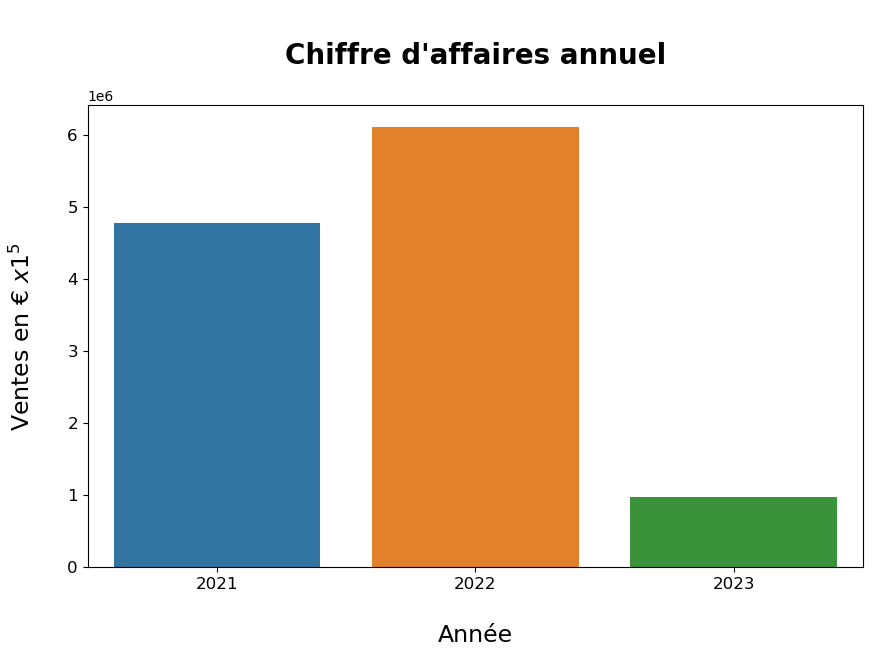

In [30]:
fig = plt.figure(figsize = (10, 6))
sns.barplot(data=ca_annee, x=ca_annee["année"], y=ca_annee["price"])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Ventes en € $x1^5$""\n", fontsize=17)
plt.xlabel("\n""Année", fontsize=17)
plt.title("\n""Chiffre d'affaires annuel""\n", fontsize=20, fontweight="bold")
plt.show()

In [31]:
# Affichage du chiffre d'affaires par année et par catégorie
ca_annee_cat = all_data[["année", "price", "categ"]].groupby(["année", "categ"]).sum().reset_index()
ca_annee_cat

,année,categ,price
0,2021,0,1883020.45
1,2021,1,1777995.85
2,2021,2,1109810.26
3,2022,0,2192970.46
4,2022,1,2485275.19
5,2022,2,1430436.16
6,2023,0,343740.06
7,2023,1,390451.65
8,2023,2,240028.60


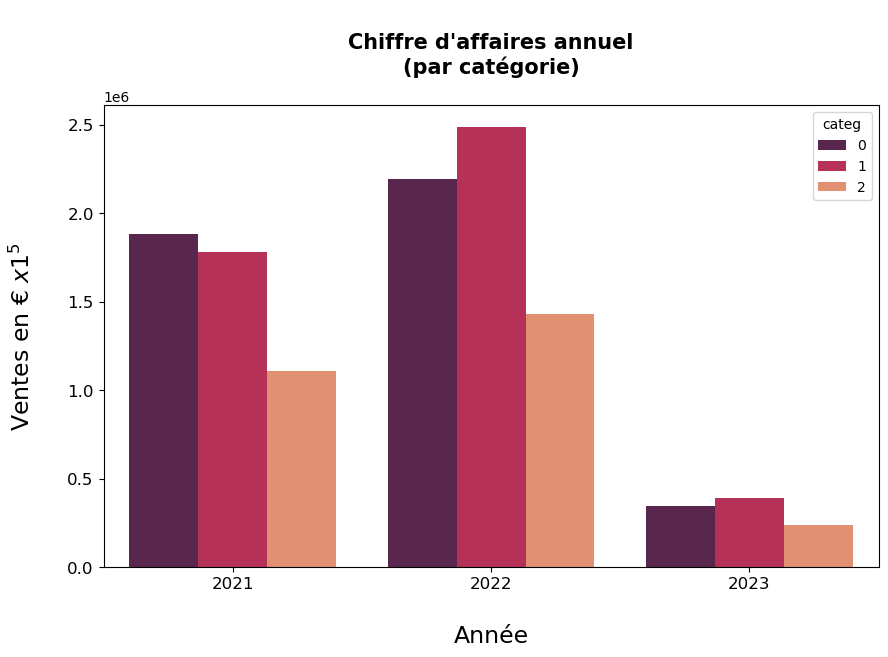

In [32]:
# Illustration du chiffre d'affaires par année et par catégorie
fig = plt.figure(figsize = (10, 6))
sns.barplot(data=ca_annee_cat, x="année", y="price", hue="categ", palette="rocket")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Ventes en € $x1^5$""\n", fontsize=17)
plt.xlabel("\n""Année", fontsize=17)
plt.title("\n""Chiffre d'affaires annuel\n(par catégorie)\n", fontsize=15, fontweight="bold")
plt.show()

#### <ins>Observations</ins>  
Nous constatons que la catégorie 1 est parmi les plus populaires suivi de la catégorie 0 et pour finir la catégorie 3. 

### 2.1.2 : CA par mois <a class="anchor" id="section_2_1_2"></a>

In [33]:
# Création de la table ca_month
ca_month = all_data[["date", "price", "année", "mois"]].groupby(["année", 'mois']).sum().reset_index()

# Création de la colonne temps
ca_month["temps"] = ca_month["mois"].astype(str)+"/"+ca_month["année"].astype(str).str[2:]

ca_month.head()

,année,mois,price,temps
0,2021,3,482440.61,3/21
1,2021,4,476109.30,4/21
2,2021,5,492943.47,5/21
3,2021,6,484088.56,6/21
4,2021,7,482835.40,7/21


In [34]:
# Création de la table ca_cat_intermédiaire, nécéssaire à la table finale ca_cat
ca_cat_intermediaire = all_data[["price", "categ", "mois", "année"]].groupby(["année", "mois", "categ"]).sum().reset_index()

# Création de la variable temps
ca_cat_intermediaire["temps"] = ca_cat_intermediaire["mois"].astype(str)+"/"+ca_cat_intermediaire["année"].astype(str).str[2:]

# Création de la table ca_cat
ca_cat = ca_cat_intermediaire[["categ", "price", "temps"]].groupby(["temps", "categ"]).sum().reset_index()

ca_cat.head()

,temps,categ,price
0,1/22,0,164210.51
1,1/22,1,256267.92
2,1/22,2,104860.56
3,1/23,0,181283.06
4,1/23,1,210104.41


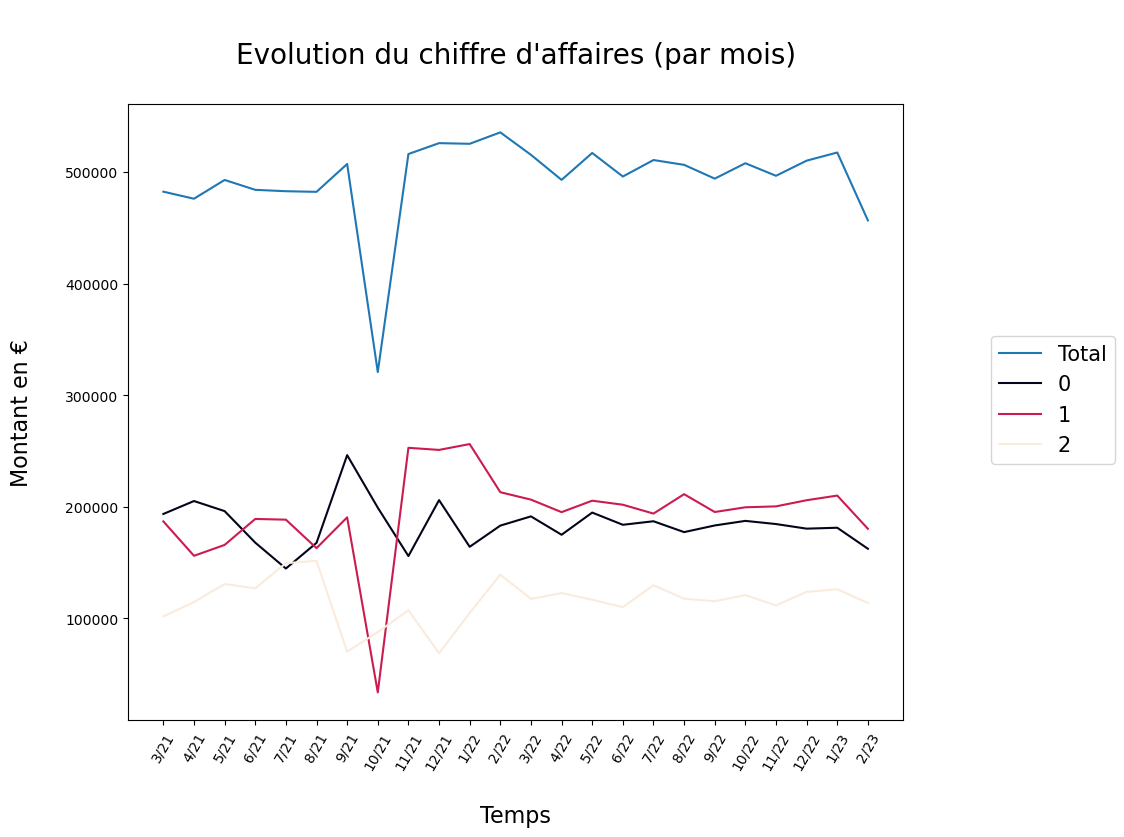

In [35]:
# Affichage graphique de l'évolution du CA par par 

plt.figure(figsize=(10, 8))
sns.lineplot(data=ca_month, x="temps", y="price", label="Total")
sns.lineplot(data=ca_cat, x='temps', y='price', hue='categ', palette='rocket')
plt.title("\n""Evolution du chiffre d'affaires (par mois)""\n", fontsize=20)
plt.xticks(rotation = 60)
plt.ylabel("Montant en €""\n", fontsize=16)
plt.xlabel("\n""Temps", fontsize=16)
plt.legend(loc="lower left", bbox_to_anchor=(1.1, 0.4), fontsize=15)
plt.grid(False)

### <ins>Observation</ins>  
***
Nous pouvons observer une légère augmentation du Chiffre d'Affaires dans le temps. Cependant, nous observons une chute drastique du CA en Octobre 2021. Nous allons examiner les ventes par catégorie au cours du mois d'Octobre 2021.

Text(0.5, 1.0, 'CA en Octobre 2021')

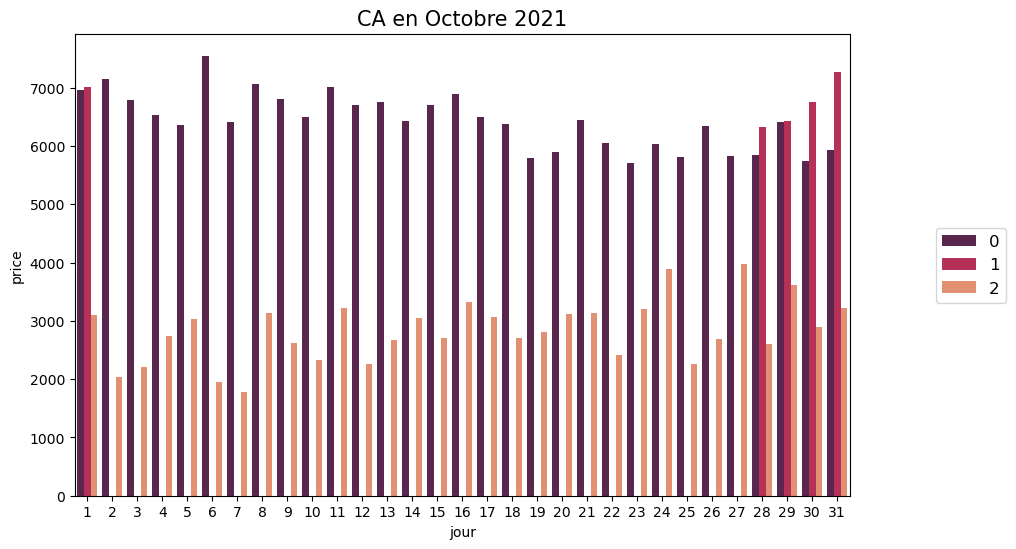

In [36]:
# Selection du CA du mois d'octobre 2022
ca_octobre = all_data[(all_data["date"]>="2021-10-01 00:00:00") & (all_data["date"]<"2021-11-01 00:00:00")]

# Création de la colonne jour
ca_octobre["jour"] = ca_octobre["date"].dt.day

# Récupération du CA par jour et par catégorie
ca_octobre_jour = ca_octobre[["jour", "categ", "price"]].groupby(['jour', 'categ']).sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=ca_octobre_jour, x="jour", y="price", hue="categ", palette="rocket")
plt.legend(loc="lower left", bbox_to_anchor=(1.1, 0.4), fontsize=12)
plt.title("CA en Octobre 2021", size=15)

### <ins>Observations<ins>:  
La chute du CA en Octobre 2021 est liée au nombre de vente de livre de catégoie 1 très faible ce mois-ci. La catégorie 1 étant habituellement la plus vendu, plusieurs pistes pourrais expliquer cette baisse :  
- Problème d'approvisionnement   
- Rupture de stok  
- Incidence sur le site
    
Se renseigner auprès des gestionnaires du site pour comprendre ce qui s'est passé. 

### 2.1.4 : CA par âge <a class="anchor" id="section_2_1_4"></a>

In [37]:
# Création de la colonne age dans la dataframe all_data
all_data["age"] = 2023-all_data["birth"]

In [38]:
# Création des tables contenant les ventes en volume et en valeur par rapport à l'age
ca_age_val = all_data[["price", "age"]].groupby("age").sum().reset_index()
ca_age_vol = all_data[["id_prod", "age"]].groupby("age").count().reset_index()

# Jointure des 2 tables
ca_age = ca_age_val.merge(ca_age_vol, how="inner", on='age')

# Renommer les colonnes de la table ca_age
ca_age.columns = ["age", "price", "nbr_vente"]

# Création de la colonne tranche
bin_labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65<"]
ca_age["tranche"], bin_values = pd.cut(
    x=ca_age["age"],
    bins=[18, 24, 34, 44, 54, 64, 100],
    labels=bin_labels,
    retbins=True,
)

ca_age.head()

,age,price,nbr_vente,tranche
0,19,609013.69,15149,18-24
1,20,178195.78,4371,18-24
2,21,184177.35,4584,18-24
3,22,178497.70,4252,18-24
4,23,165007.98,4413,18-24


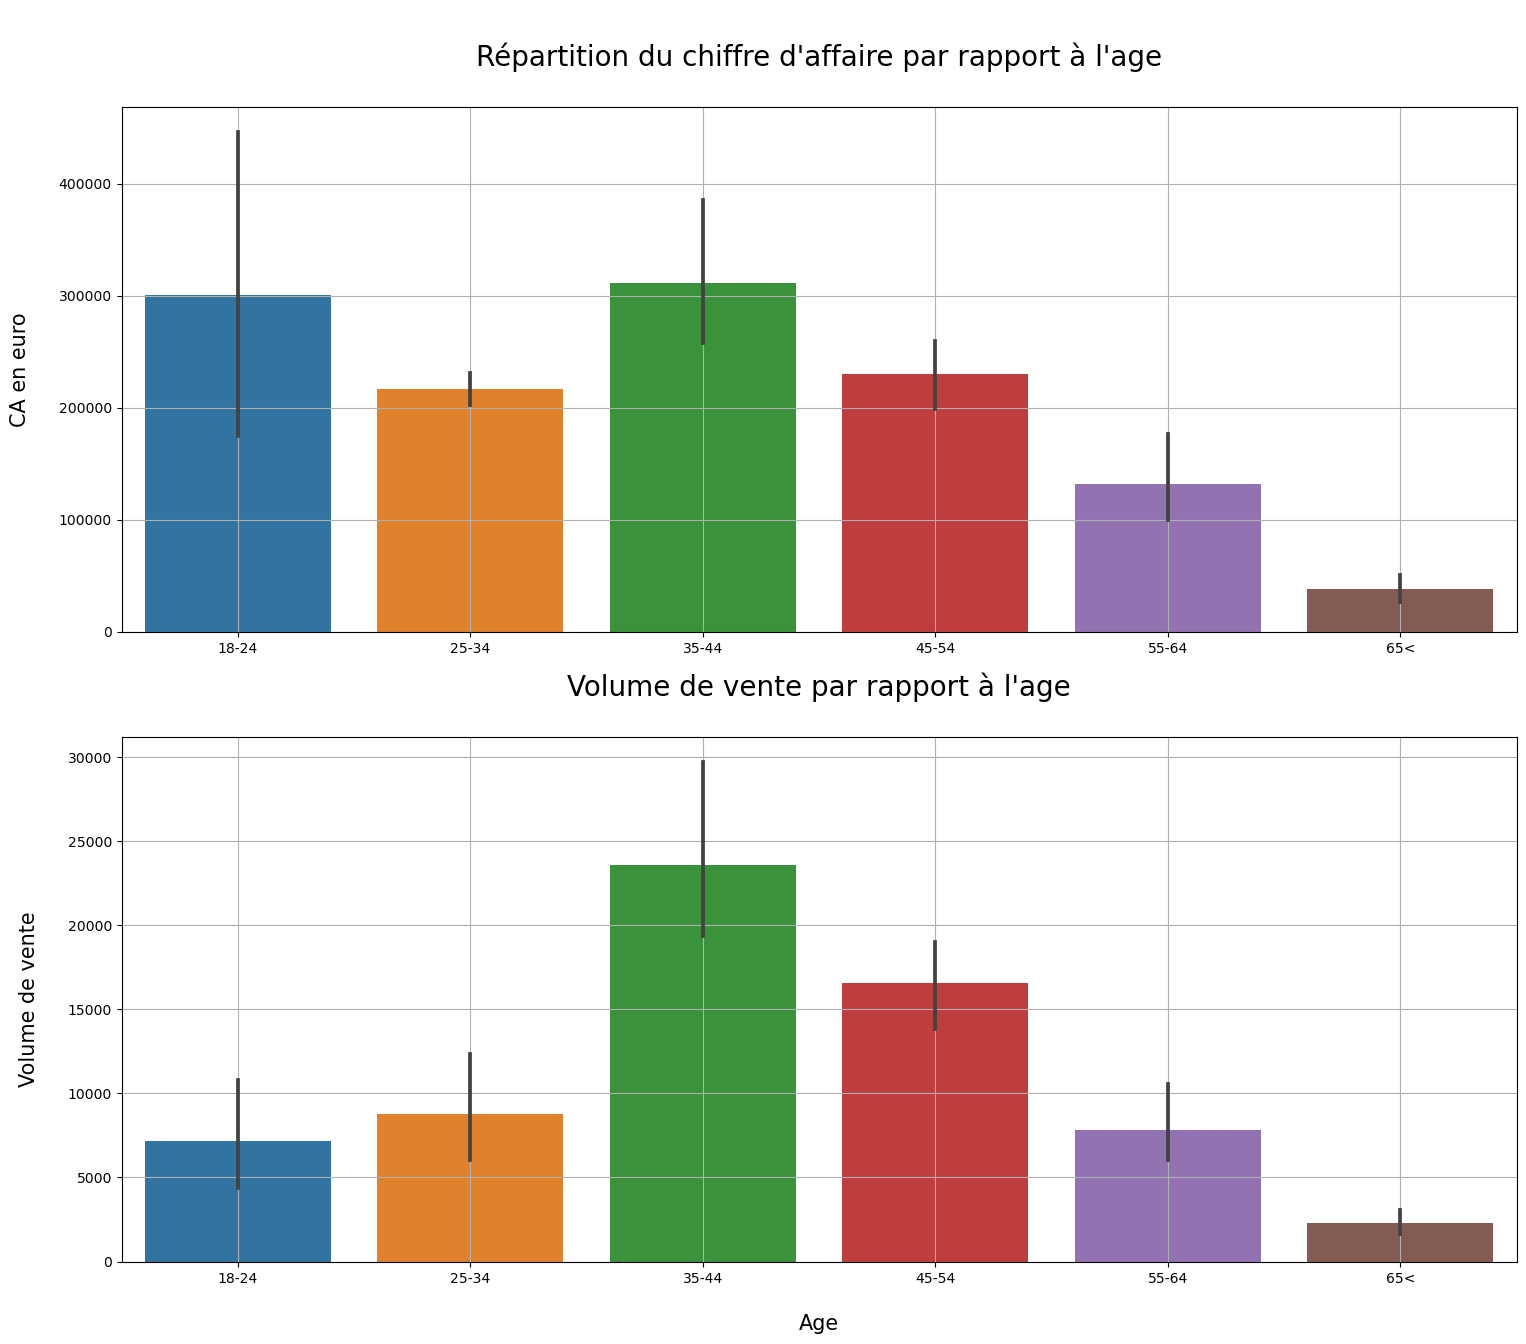

In [39]:
# Affichage du CA par rapport à l'age
plt.figure(figsize=(18, 15))
plt.subplot(2, 1, 1)
sns.barplot(data=ca_age, x=ca_age["tranche"], y=ca_age["price"])
plt.xlabel("")
plt.ylabel("CA en euro""\n", fontsize=15)
plt.title("\n""Répartition du chiffre d'affaire par rapport à l'age""\n", fontsize=20)
plt.grid(True)

# Affichage du volume de vente 
plt.subplot(2, 1, 2)
sns.barplot(data=ca_age, x=ca_age["tranche"], y=ca_age["nbr_vente"])
plt.xlabel("\n""Age", fontsize=15)
plt.ylabel("Volume de vente""\n", fontsize=15)
plt.title("\n""Volume de vente par rapport à l'age""\n", fontsize=20)
plt.grid(True)
plt.show()

### <ins>Observations</ins>
Nous pouvons observer que les 35-44 ans sont ceux qui consomment le plus sur le site et ceux qui rapportent le plus de chiffre d'affaire. 
Nous pouvons également observer que les 18-24 sont ceux qui consomment le moins mais sont les 2ème en matière du plus gros chiffre d'affaires.

### 2.1.5 : CA par genre <a class="anchor" id="section_2_1_5"></a>

Nous allons créer deux tables distinguant les genres

In [40]:
# Création de la table du genre m
ca_m = all_data[all_data["sex"]=="m"]
ca_m = ca_m[["année", "mois", "price"]].groupby(["année", "mois"]).sum().reset_index()

# Création de la colonne temps
ca_m["temps"] = ca_m["mois"].astype(str)+"/"+ca_m["année"].astype(str).str[2:]



# Création de la table du genre f
ca_f = all_data[all_data["sex"]=="f"]
ca_f = ca_f[["année", "mois", "price"]].groupby(["année", "mois"]).sum().reset_index()

# Création de la colonne temps
ca_f["temps"] = ca_f["mois"].astype(str)+"/"+ca_f["année"].astype(str).str[2:]


# Jointure des tables homme et femme
ca_genre = ca_m.merge(ca_f[["price", "temps"]], how="inner", on="temps")

# Mise en forme de la nouvelle table
ca_genre.rename(columns={'price_x': 'ca_homme', 
                         'price_y': 'ca_femme'}, inplace=True)

ca_genre = ca_genre[["année", "mois", "ca_homme", "ca_femme", "temps"]]

ca_genre.head()

,année,mois,ca_homme,ca_femme,temps
0,2021,3,246677.02,235763.59,3/21
1,2021,4,239019.52,237089.78,4/21
2,2021,5,246307.50,246635.97,5/21
3,2021,6,246708.14,237380.42,6/21
4,2021,7,246568.10,236267.30,7/21


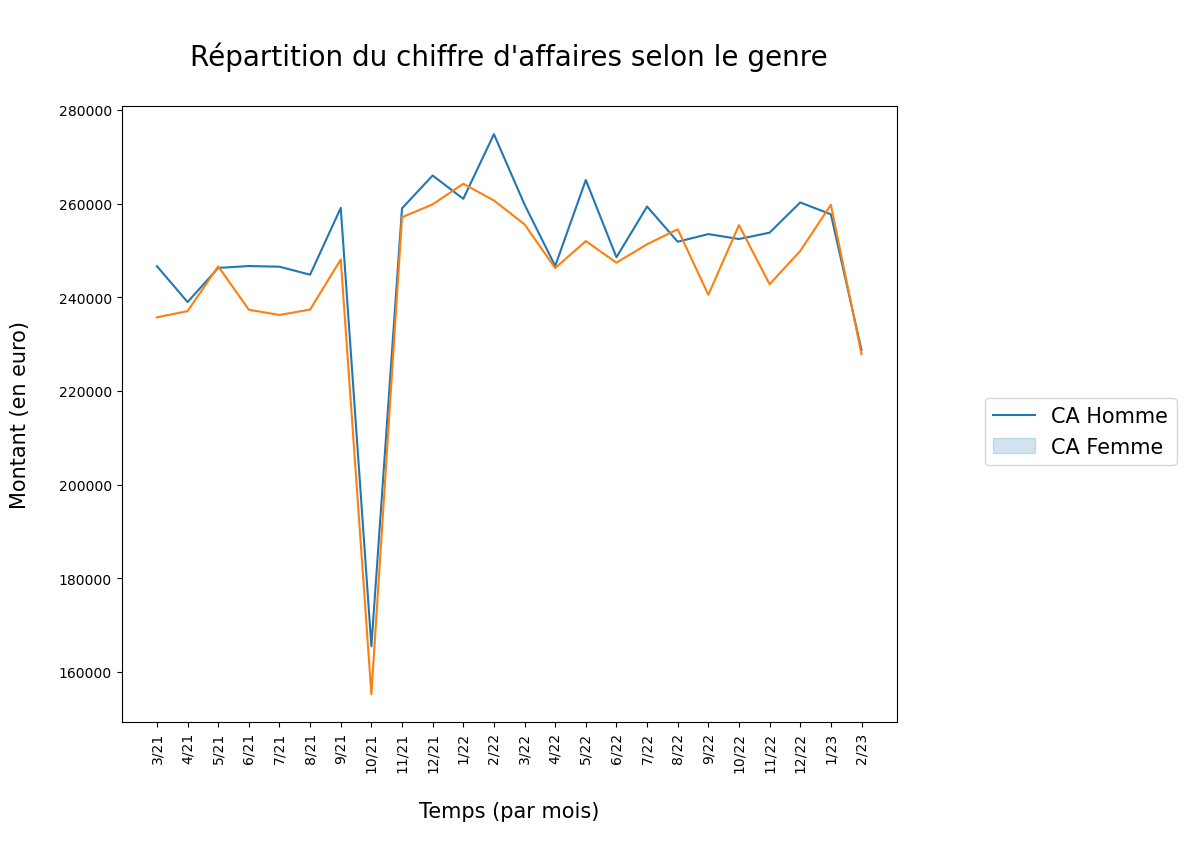

In [41]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=ca_genre, x="temps", y="ca_homme")
sns.lineplot(data=ca_genre, x="temps", y="ca_femme")
plt.title("\n""Répartition du chiffre d'affaires selon le genre""\n", fontsize=20)
plt.xlabel("\n""Temps (par mois)""\n", fontsize=15)
plt.ylabel("Montant (en euro)""\n", fontsize=15)
plt.xticks(rotation=90)
plt.legend(["CA Homme", "CA Femme"], loc="lower left", bbox_to_anchor=(1.1, 0.4), fontsize=15)
plt.show()

### <ins>Observations</ins>  
Les hommes et les femmes dépensent autant sur le site. une panier moyen légèrement plus élevé chez les hommes.

## 2.2 : La moyenne mobile <a class="anchor" id="section_2_2"></a>

In [42]:
all_data["date"] = all_data["date"].apply(pd.Timestamp)

In [43]:
# Tri par ordre chronologique
all_data.sort_values("date", inplace=True)

# Utilisation de la colonne date en index
all_data.index = all_data["date"]

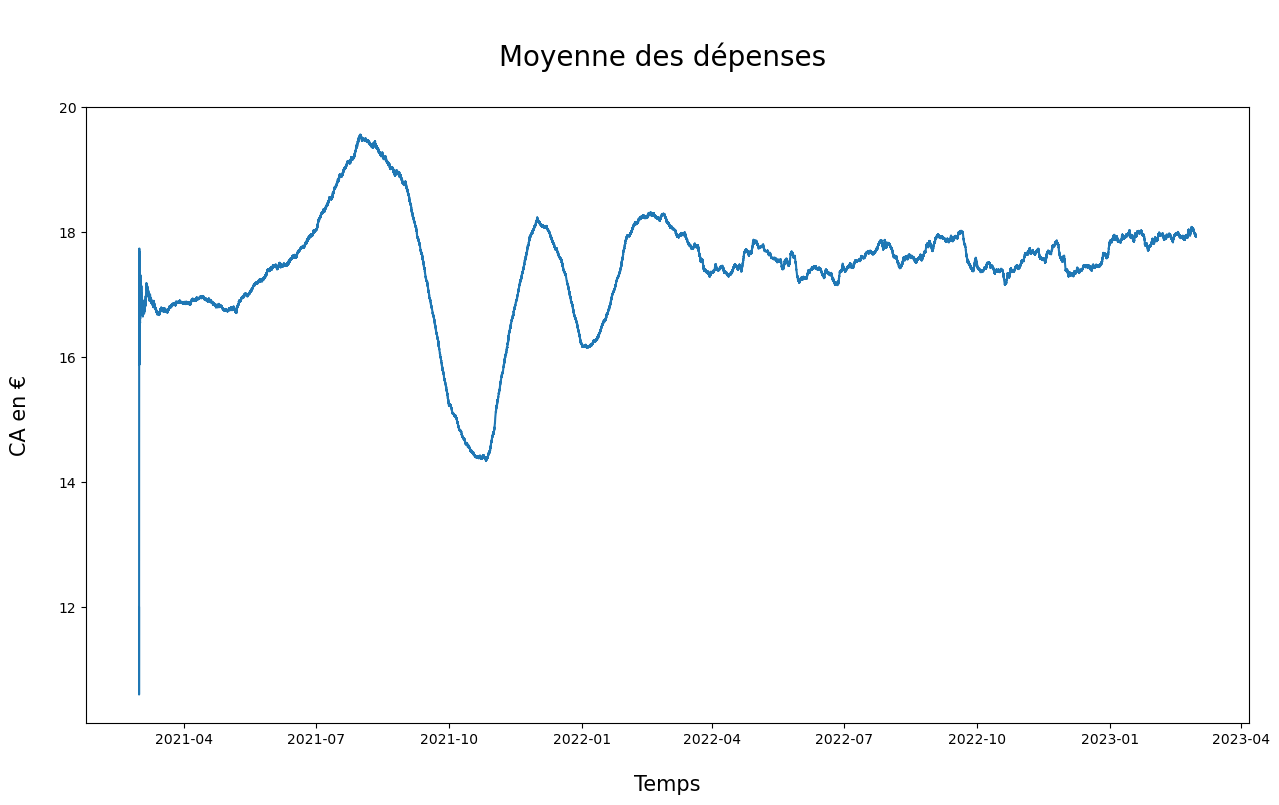

In [44]:
# Création de la table pour la visualisation graphiques de la moyenne mobile
all_data_ma_on_month = all_data[["price"]].rolling('30d').mean()

plt.figure(figsize=(15, 8))
plt.plot(all_data_ma_on_month)
plt.xlabel("\n""Temps", fontsize=15)
plt.ylabel("CA en €""\n", fontsize=15)
plt.title("\n""Moyenne des dépenses ""\n", fontsize=20)
plt.show()

Nous pouvons observer ce qu'un client dépense en moyenne par jour sur le site. Cette moyenne se base sur un roulement 30 jours

## 2.3 : Les tops et les flops des livres <a class="anchor" id="section_2_3"></a>

In [45]:
all_data.index = range(len(all_data))

In [46]:
# Création des tables contenant la valeur et le volume de vente pour chaque articles
livre_valeur = all_data[["id_prod", "price"]].groupby(["id_prod"]).sum().reset_index()
livre_volume = all_data[["id_prod", "price"]].groupby(["id_prod"]).count().reset_index()

# Jointure des 2 tables
ca_livre = pd.merge(livre_valeur, livre_volume, how="inner", on="id_prod")

# renommer les colonnes
ca_livre.rename(columns={'price_x': 'valeur', 
                         'price_y': 'volume'}, inplace=True)
ca_livre.head()

,id_prod,valeur,volume
0,0_0,4657.50,1242
1,0_1,5352.13,487
2,0_10,394.90,22
3,0_100,61.80,3
4,0_1000,2954.88,432


Pour illustrer les tops et les flops, nous utiliserons la **courbe de Lorenz**.

In [47]:
# Tri croissant de la colonne valeur
ca_livre.sort_values("valeur", ascending=True, inplace=True)

# Calcul de la somme cumulée de la colonne valeur
ca_livre["cumsum_valeur"] = ca_livre["valeur"].cumsum()

# Somme cumulée en pourcentage
ca_livre["cum_pct_valeur"] = 100*ca_livre["cumsum_valeur"]/ca_livre["valeur"].sum()

# Classement de la population étudiée (les livres)
ca_livre["range_pop"] = range(1, len(ca_livre)+1)

# Classement en pourcentage
ca_livre["pct_pop"] = 100*ca_livre["range_pop"]/len(ca_livre)

ca_livre.head()

,id_prod,valeur,volume,cumsum_valeur,cum_pct_valeur,range_pop,pct_pop
595,0_1539,0.99,1,0.99,0.000008,1,0.030628
313,0_1284,1.38,1,2.37,0.000020,2,0.061256
719,0_1653,1.98,2,4.35,0.000037,3,0.091884
665,0_1601,1.99,1,6.34,0.000053,4,0.122511
2079,0_807,1.99,1,8.33,0.000070,5,0.153139


In [48]:
(len(ca_livre)+1)/2

1633.0

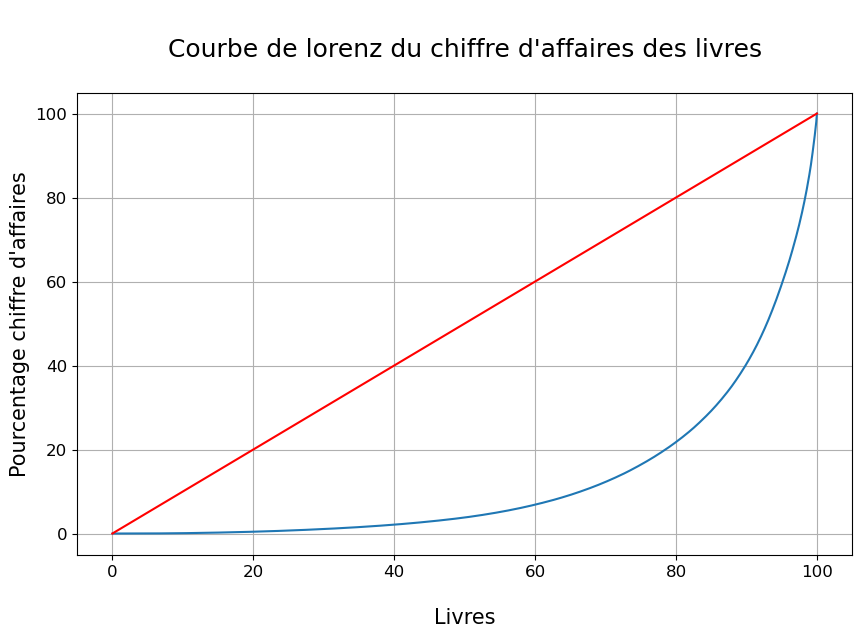

In [49]:
plt.figure(figsize=(10,6))
sns.lineplot(x="pct_pop", y="cum_pct_valeur", data=ca_livre)
plt.plot([0,100], [0,100], color='r')
plt.xlabel("\n""Livres", fontsize=15)
plt.ylabel("Pourcentage chiffre d'affaires", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("\n""Courbe de lorenz du chiffre d'affaires des livres""\n", fontsize=18)
plt.grid(True)
plt.show()

Nous pouvons observer, d'après la courbe de Lorenz, une répartition très innégale du CA par rapport aux livres. En effet, il est possible de constater que les 20 derniers pourcent réalisent à eux seuls 80% du chiffre d'affaires total du site.

In [50]:
# Récupération des 10 derniers pourcent de la population
ca_top = ca_livre[ca_livre["pct_pop"]>=90]["valeur"].sum()

# CA total
ca_total = ca_livre["valeur"].sum()

# Part du CA des tops 10%
print("La part de CA des tops 10% est de", 100*ca_top/ca_total)

La part de CA des tops 10% est de 59.65086869189248


Nous pouvons observer les 10% des articles qui constituent 60% du chiffre d'affaires.

In [51]:
# Liste des TOP livres
ca_livre[ca_livre["pct_pop"]>=90].sort_values("valeur", ascending=False).head()

,id_prod,valeur,volume,cumsum_valeur,cum_pct_valeur,range_pop,pct_pop
3096,2_159,94893.50,650,11853728.68,100.000000,3265,100.000000
3070,2_135,69334.95,1005,11758835.18,99.199463,3264,99.969372
3045,2_112,65407.76,968,11689500.23,98.614542,3263,99.938744
3034,2_102,60736.78,1027,11624092.47,98.062751,3262,99.908116
3152,2_209,56971.86,814,11563355.69,97.550366,3261,99.877489


Il est possible de retrouver ci-dessus, les 10% de la population réalisant la plus grosse part du CA. (au nombre de 327 livres)
***

In [52]:
# Récupération des 30 premiers pourcent de la population
ca_flop = ca_livre[ca_livre["pct_pop"]<=30]["valeur"].sum()

# CA total
ca_total = ca_livre["valeur"].sum()

# Part du CA des flops 30%
print("La part de CA des flops 30% est de", 100*ca_flop/ca_total)

La part de CA des flops 30% est de 1.0722634491748804


Nous pouvons constater que pour les 30 premiers pourcent de la population étudiée réalisent 1.07% du chiffre d'affaire en ligne.

Il serait interessant de se pencher sur cette liste et tenter de comprendre les raisons de ces flops. Il est possible de les retrouver ci-dessous.

In [53]:
# Liste des 30% Flop livre
ca_livre[ca_livre["pct_pop"]<=30].sort_values("valeur", ascending=True).head()

,id_prod,valeur,volume,cumsum_valeur,cum_pct_valeur,range_pop,pct_pop
595,0_1539,0.99,1,0.99,0.000008,1,0.030628
313,0_1284,1.38,1,2.37,0.000020,2,0.061256
719,0_1653,1.98,2,4.35,0.000037,3,0.091884
665,0_1601,1.99,1,6.34,0.000053,4,0.122511
2079,0_807,1.99,1,8.33,0.000070,5,0.153139


***

# Partie 3 : Tests statistiques <a class="anchor" id="chapter3"></a>

Dans cette partie, nous tenterons de confirmer ou infirmer les relations entre deux variables. Pour ce faire, nous réaliserons des tests paramétriques et/ou non-parametriques.

## 3.1 : La relation entre les ventes par catégories et le genre <a class="anchor" id="section_1_1"></a>

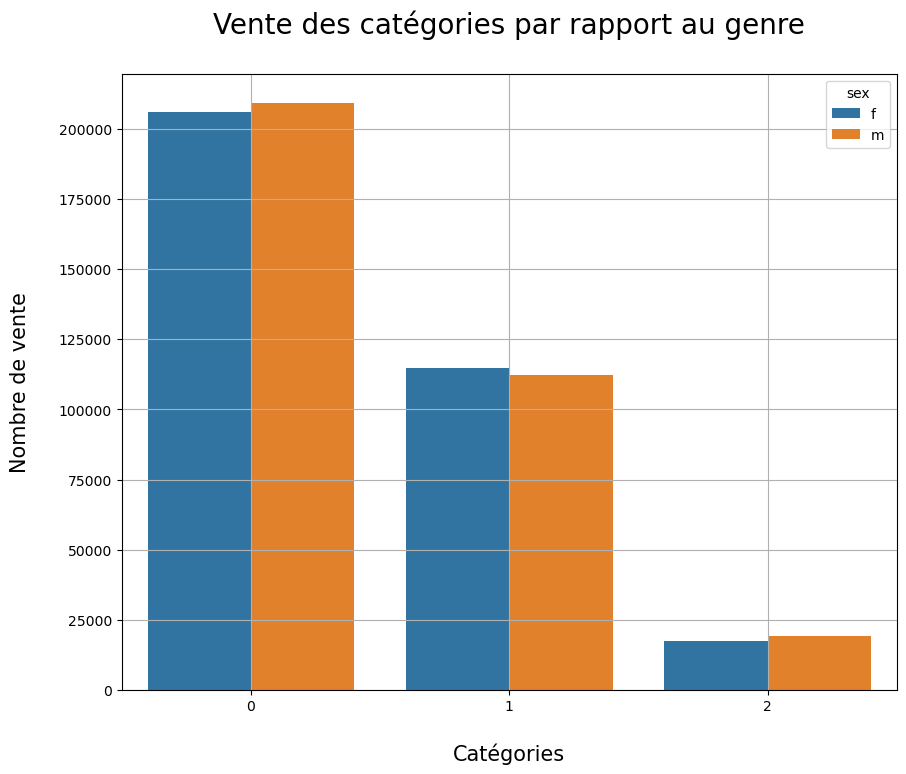

In [54]:
plt.figure(figsize=(10,8))
sns.countplot(x="categ", hue="sex", data=all_data)
plt.title("Vente des catégories par rapport au genre""\n", fontsize=20)
plt.xlabel("\n""Catégories", fontsize=15)
plt.ylabel("Nombre de vente""\n", fontsize=15)
plt.grid(True)
plt.show()

In [55]:
# Tableau de contingeance
cont_sex_categ = pd.crosstab(all_data["categ"], all_data["sex"], margins=True, margins_name="total")
cont_sex_categ

sex,f,m,total
categ,,,
0,206103,209356,415459
1,114899,112270,227169
2,17283,19200,36483
total,338285,340826,679111


In [56]:
# Test de Chi2

# H0 : Les ventes selon les catégories ne dépendent pas du genre.
# H1 : Les ventes selon les catégories dépandent du genre.

c, p, dof, expected = stats.chi2_contingency(cont_sex_categ)
print(p)
print(c)

3.144522803251581e-29
147.11906816131497


La P-value etant <0.05 donc nous pouvons rejeter la 1ère hypothèse et affirmer que les ventes selon les catégories dépandent du genre.

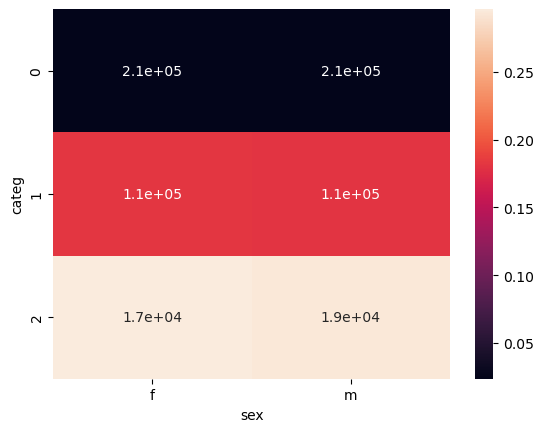

In [57]:
tx = cont_sex_categ.loc[:,["total"]]
ty = cont_sex_categ.loc[["total"], :]
n = len(all_data)
indep = tx.dot(ty) / n

c= cont_sex_categ.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()

Nous pouvons observer que la catégorie 0 contribue fortement à la corrélation entre les variables. Concernant la catégorie 1, sa valeur se situe autours de 0,20 donc nous pouvons dire qu'elle contribue moyennement à la correlation de ces deux variables (catégorie et genre)

comparaison 

## 3.2 : La correlation entre l'age et le Chiffre d'Affaires <a class="anchor" id="section_3_2"></a>

Nous réutiliserons la dataframe **ca_age** que nous avons créé dans la section 2.1.4

In [58]:
ca_age.head()

,age,price,nbr_vente,tranche
0,19,609013.69,15149,18-24
1,20,178195.78,4371,18-24
2,21,184177.35,4584,18-24
3,22,178497.70,4252,18-24
4,23,165007.98,4413,18-24


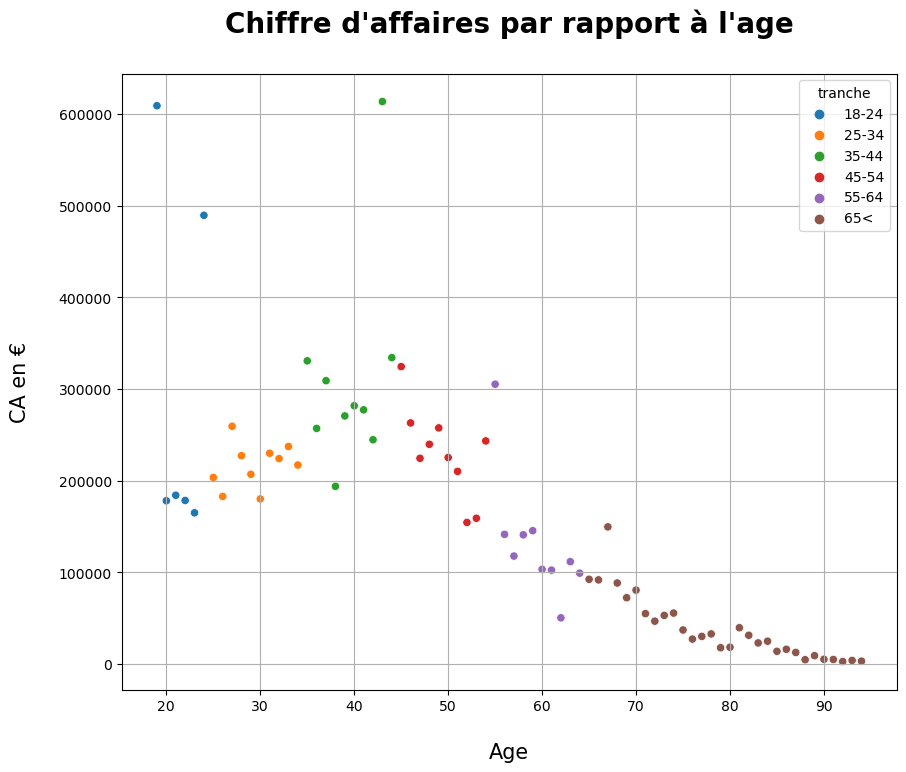

In [59]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="age", y="price", data=ca_age, hue="tranche")
plt.xlabel("\n""Age", fontsize=15)
plt.ylabel("CA en €""\n", fontsize=15)
plt.title("Chiffre d'affaires par rapport à l'age""\n", fontsize=20, fontweight="bold")
plt.grid(True)
plt.show()

Nous pouvons observer que plus l'age est élevé, plus le chiffre d'affaires est bas. Vérifions à présent si cette affirmation est vraie statistiquement ou simplement dû au fait du hasard. 

Dans ce contexte, nous tentons de vérifier la corrélation entre 2 variables qualitatives, par conséquent, nous réaliserons le **test d'association de Pearson** sous réserve de la validité des conditions de validité qui lui sont asssociées :

* la variable ca_age["price"] doit suivre une distribution normale
* Au moins 20 individus dans l'échantillon (recommandé)

La 2ème condition etant validé, nous nous pencherons sur la 1ère condition. Pour se faire, nous utiliserons **le test de normalité de Jarque-Bera**.

In [60]:
# Test de normalité de Jarque-Bera

# H0 : La distribution du CA par rapport à l'age suit une loi normale (p_value > 0.05)
# H1 : La distribution du CA par rapport à l'age ne suit pas une loi normale (p_value < 0.05)

stats.jarque_bera(ca_age["price"])

SignificanceResult(statistic=31.71373238226762, pvalue=1.2985255907056087e-07)

Nous pouvons constater que la p-value issue du test de Jarque-Bera est inférieur à 0.05 donc nous pouvons rejeter l'hypothèse H0.

Conclusion, nous ne pouvons pas utiliser le test paramétrique de Pearson car la 1ère condition de validité d'application de Pearson n'est pas respecté. (la variable "age" ne suit pas une loi normale.

De ce fait, pour répondre à notre question initiale, nous utiliserons le test non-paramétrique de Spearman

In [61]:
# Test de corrélation de Spearman

# H0 : Il n'y a pas de corrélation entre le CA et l'age (p_value > 0.05)
# H1 : Il y a une corrélation entre le CA et l'age (p_value < 0.05)

stats.spearmanr(ca_age["age"], ca_age["price"])

SignificanceResult(statistic=-0.8576076555023923, pvalue=4.57972879340901e-23)

Nous constatons qu'il y a une très forte dépendance entre l'age et le montant d'achat. 

De plus, il existe un lien statistique linéaire négatif très fort entre l'age et le montant d'achat parmis les clients. En effet, plus le client est agé, moins il achètera de livre. 

## 3.3 : La relation entre l'age et la fréquence d'achat <a class="anchor" id="section_3_3"></a>

In [62]:
freq = all_data.groupby(["age", "client_id"])["price"].count().reset_index()

# Création de la colonne tranche d'age
bin_labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65<"]

freq["tranche"], bin_values = pd.cut(
    x=freq["age"],
    bins=[18, 24, 34, 44, 54, 64, 100],
    labels=bin_labels,
    retbins=True)

# Frequence 
freq["freq"] = freq["price"]/24

# Suppression des outliers
freq["z_score"] = (freq["freq"] - freq["freq"].mean()) / freq["freq"].std() 
freq = freq[freq["z_score"].abs()<3]

# Renommer la colonne price -> nbr_vente
freq.rename(columns={'price': 'nbr_vente'}, inplace=True)

freq.head()

,age,client_id,nbr_vente,tranche,freq,z_score
0,19,c_1042,12,18-24,0.500000,-0.214359
1,19,c_1046,41,18-24,1.708333,-0.121530
2,19,c_1065,27,18-24,1.125000,-0.166344
3,19,c_1088,13,18-24,0.541667,-0.211158
4,19,c_109,7,18-24,0.291667,-0.230364


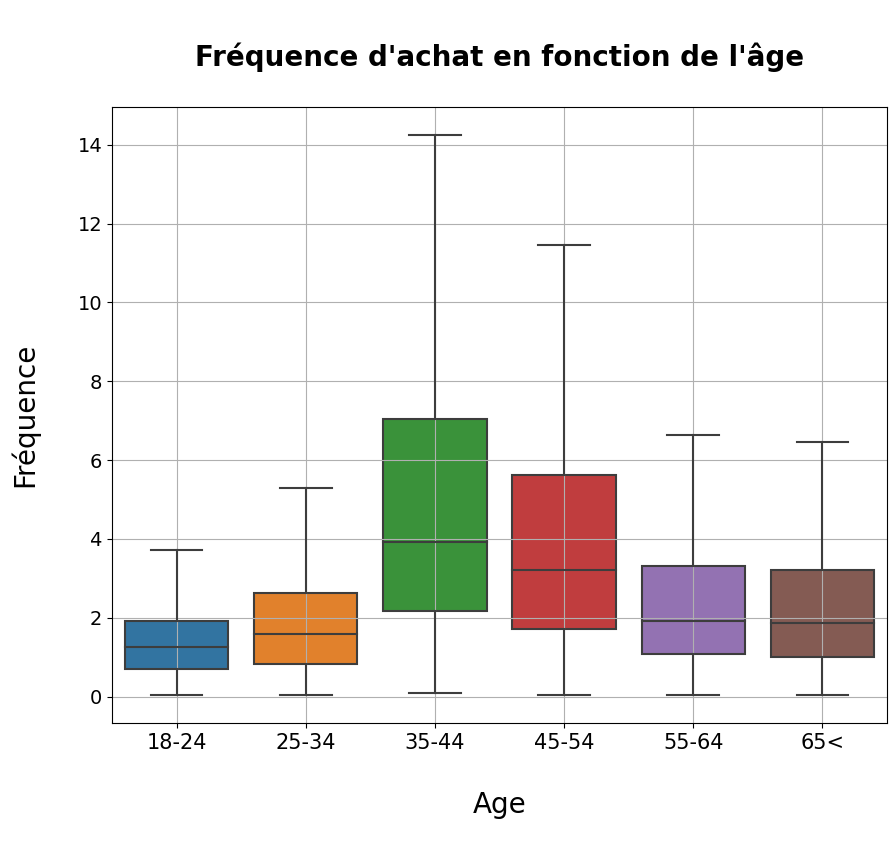

In [63]:
plt.figure(figsize=(10,8))
sns.boxplot(data=freq, x="tranche", y="freq", showfliers = False)
plt.title("\n""Fréquence d'achat en fonction de l'âge""\n", fontsize=20, fontweight="bold")
plt.xlabel("\n""Age""\n", fontsize=20)
plt.ylabel("Fréquence""\n", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

Aux premiers abors, nous pouvons observer que plus on se rapproche de la tranche d'age 35-44 ans, plus la fréquence d'achat augmente.

Afin de vérifier le lien entre la fréquence et l'age, nous allons réaliser un test paramétrique d'ANOVA. Pour cela, nous allons tout d'abords vérifier les conditions de validité du test :

* Les mesures sont indépendantes
* Les résidus suivent une distribution normale (supposée ou vérifiée)
* Les échantillons ont des variances égales
* Au moins 20 individus dans le dispositif, ou normalité des résidus supposée ou vérifiée

## 3.3.1 : Analyse de la distribution des données

<Figure size 640x480 with 0 Axes>

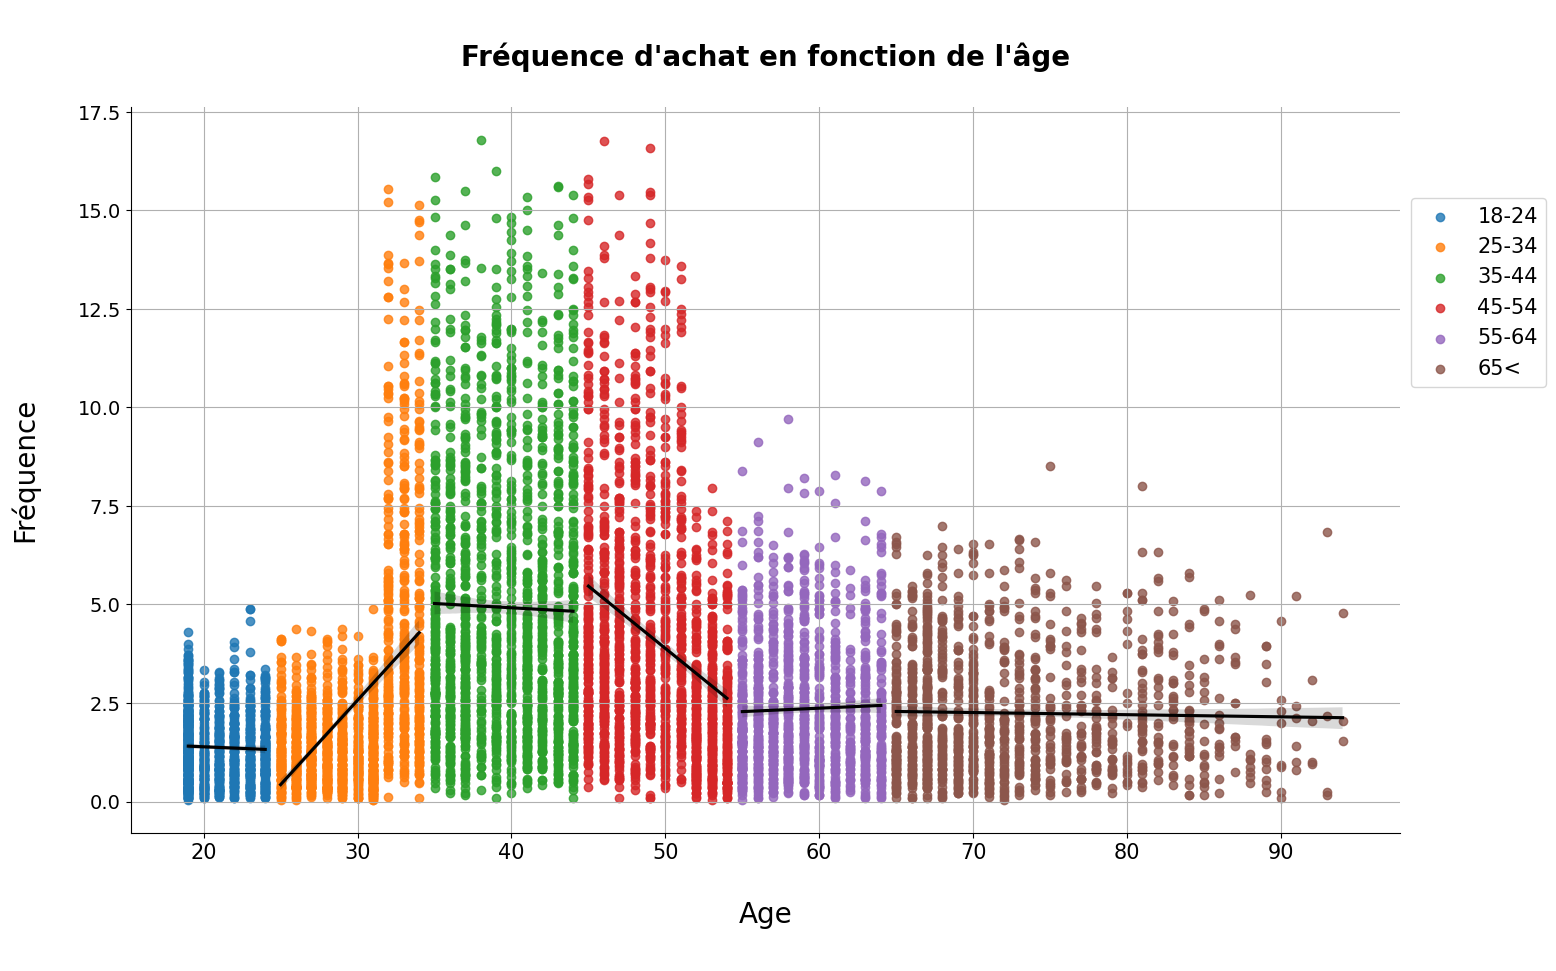

In [64]:
plt.figure()
sns.lmplot(
    data=freq.sort_values("tranche"),
    x="age",
    y="freq",
    hue="tranche",
    height=8,
    aspect=1.7,
    line_kws={"color": "black"},
    legend = False)
plt.title("\n""Fréquence d'achat en fonction de l'âge""\n", fontsize=20, fontweight="bold")
plt.xlabel("\n""Age""\n", fontsize=20)
plt.ylabel("Fréquence""\n", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.6), fontsize=15)
plt.grid(True)
plt.show()

In [65]:
# Coefficient d'asymétrie du Chiffre d'affaires
print("coef d'asymétrie : ",freq["freq"].skew())

# Coef d'applatissement
print("Coef d'aplatissement :", freq["freq"].kurtosis())

coef d'asymétrie :  1.7617478773623965
Coef d'aplatissement : 3.157895846070405


Une loi normale a un coefficient d'asymétrie de 0, dans notre cas, le coef d'asymétrie est de 1.76 donc nous pouvons observer une asymétrie positiv, s'étalant sur la droite.

Une loi normale a un coefficient d'applatissement égale à 0, dans notre cas, le coef d'aplatissement est de 3.15 donc nous pouvons obeserver un applatissement élevé avec une concentration élevé autours du mode.

In [66]:
# Test de normalité de Jarque-Bera

# H0 : La distribution de la fréquence suit une loi normale (p-value > 0.05)
# H1 : La distribution de la fréquence ne suit pas une loi normale (p-value < 0.05)

print(stats.jarque_bera(freq["freq"]))

SignificanceResult(statistic=8011.112095263385, pvalue=0.0)


Nous avons une p-value = 0 donc nous pouvons rejeter l'hypothèse H0 et conclure en effirmant que la distribution de la fréquence ne suit pas de loi normale.

Nous constatons qu'une des conditions du test d'ANOVA n'est pas respectée de ce fait, nous réaliserons un test non-paramétrique, celui de Kruskal-Wallis

In [67]:
# Création de liste
tranche_age = list(freq["tranche"].unique())

# Création de liste
pop_tas = list()

for ta in tranche_age :
    pop_ta = freq[freq["tranche"] == ta]["freq"]
    pop_tas.append(pop_ta)
pop_tas

[0       0.500000
 1       1.708333
 2       1.125000
 3       0.541667
 4       0.291667
           ...   
 1142    0.416667
 1143    0.166667
 1144    1.291667
 1145    0.750000
 1146    3.083333
 Name: freq, Length: 1146, dtype: float64,
 1147    1.208333
 1148    0.666667
 1149    1.958333
 1150    0.208333
 1151    1.375000
           ...   
 2703    2.416667
 2704    1.458333
 2705    3.083333
 2706    1.125000
 2707    2.166667
 Name: freq, Length: 1561, dtype: float64,
 2708    5.375000
 2709    3.291667
 2710    4.625000
 2711    2.000000
 2712    8.791667
           ...   
 4483    4.041667
 4484    9.750000
 4485    6.083333
 4486    4.958333
 4487    1.416667
 Name: freq, Length: 1779, dtype: float64,
 4488     1.833333
 4489    13.291667
 4490     1.916667
 4491     2.458333
 4492     5.458333
           ...    
 6093     2.958333
 6094     0.708333
 6095     1.541667
 6096     0.583333
 6097     0.750000
 Name: freq, Length: 1609, dtype: float64,
 6098    3.500000
 6099  

In [68]:
# Test de Levene : Comparaison des variances

# H0 : Il n'y a aucune différence significative entre les variances (p-value > 0.05)
# H1 : Il y a une différence significative entre les variances (p-value < 0.05)

stats.levene(*pop_tas)

LeveneResult(statistic=253.6094335685381, pvalue=1.4447746621130214e-253)

Nous constatons que les fréquences des différentes tranches d'age ne partagent pas la même variance, ce qui confirme que l'on ne peut pas réaliser de test paramétrique d'ANOVA entre la fréquence d'achat et la tranche d'age. De ce fait, nous allons utiliser le test non-paramétrique de Kruskal-Wallis

In [69]:
# test d'égalité de toutes les médianes

stats.kruskal(*pop_tas)

KruskalResult(statistic=1785.1019765217031, pvalue=0.0)

In [70]:
# Test de Kruskal-Wallis

# H0 : La différence entre les médianes n'est pas significatives (p-value > 0.05)
# H1 : La différence entre les médianes est significatives (p-value < 0.05)

# Création d'une boucle permettant de faire les différentes comparaisons de la p-value entre les tranches d'age
D = dict()
for ta in tranche_age :
    pop_ta = freq[freq["tranche"] == ta]["freq"]
    for ta_2 in tranche_age :
      if ta < ta_2 :
            pop_ta_2 = freq[freq["tranche"] == ta_2]["freq"]
            _, p = stats.kruskal(pop_ta, pop_ta_2)
            D[(ta, ta_2)] = p
D

{('18-24', '25-34'): 1.3129406552558606e-18,
 ('18-24', '35-44'): 7.012343454740076e-248,
 ('18-24', '45-54'): 2.5376516345667779e-172,
 ('18-24', '55-64'): 1.7134106005763667e-48,
 ('18-24', '65<'): 6.22321759887078e-42,
 ('25-34', '35-44'): 1.6646577709330536e-157,
 ('25-34', '45-54'): 2.467152150216904e-91,
 ('25-34', '55-64'): 2.3374864716864218e-08,
 ('25-34', '65<'): 8.737547712020375e-06,
 ('35-44', '45-54'): 3.71898979062456e-13,
 ('35-44', '55-64'): 4.451220373503508e-111,
 ('35-44', '65<'): 3.025513281731371e-124,
 ('45-54', '55-64'): 6.613553530813387e-55,
 ('45-54', '65<'): 5.684134799679979e-64,
 ('55-64', '65<'): 0.20604566630989468}

D'après le test de Kruskal-Wallis, nous pouvons observer qu'il y a une différence significatives dans la plus part des comparaisons des tranches d'age.

Nous pouvons noter une différence peu signicatif entre les tranches "55-64" et "65<"

Conclusion il existe un lien significatif entre entre l'age et la fréquence d'achat.

# 3.4 : L'age par rapport au panier moyen <a class="anchor" id="section_3_4"></a>

In [71]:
panier_m = all_data[["age", "price", "client_id"]].groupby(["age", "client_id"]).mean().reset_index()

# Création de la colonne tranche d'age
bin_labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65<"]

panier_m["tranche"], bin_values = pd.cut(
    x=panier_m["age"],
    bins=[18, 24, 34, 44, 54, 64, 100],
    labels=bin_labels,
    retbins=True,
)

panier_m.rename(columns={'price': 'panier_moyen'}, inplace=True)

panier_m

,age,client_id,panier_moyen,tranche
0,19,c_1042,29.062500,18-24
1,19,c_1046,22.428780,18-24
2,19,c_1065,41.654074,18-24
3,19,c_1088,45.420769,18-24
4,19,c_109,59.312857,18-24
...,...,...,...,...
8595,93,c_4679,10.990000,65<
8596,93,c_7232,17.853598,65<
8597,94,c_5302,14.838378,65<
8598,94,c_577,15.912696,65<


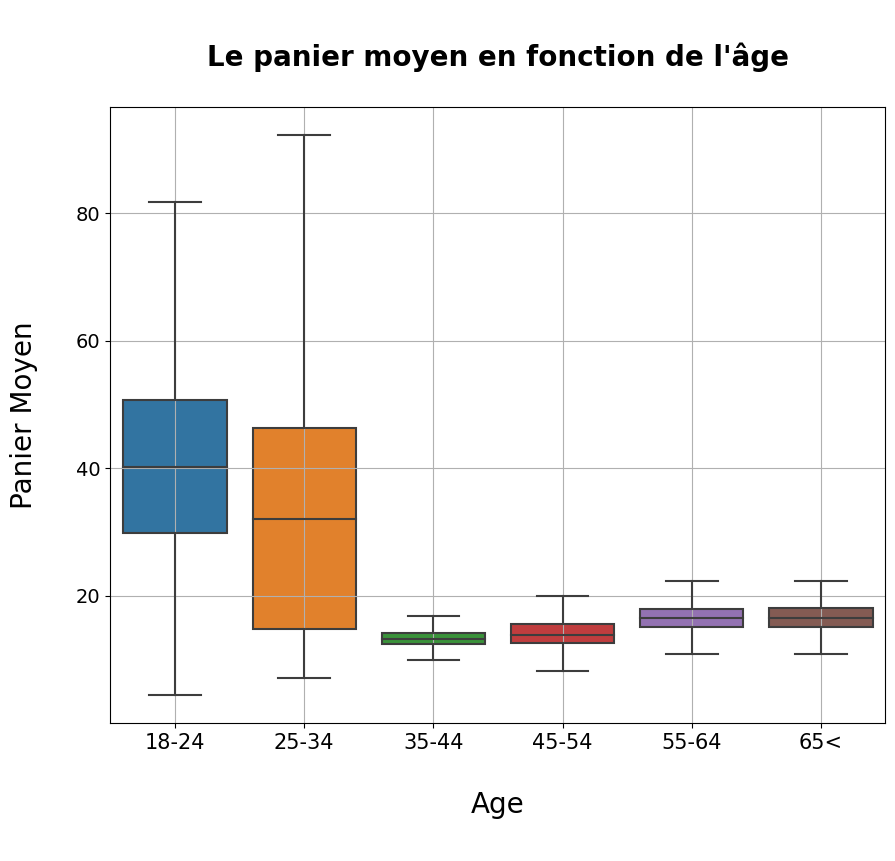

In [72]:
plt.figure(figsize=(10,8))
sns.boxplot(data=panier_m, x="tranche", y="panier_moyen", showfliers=False)
plt.title("\n""Le panier moyen en fonction de l'âge""\n", fontsize=20, fontweight="bold")
plt.xlabel("\n""Age""\n", fontsize=20)
plt.ylabel("Panier Moyen""\n", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()           

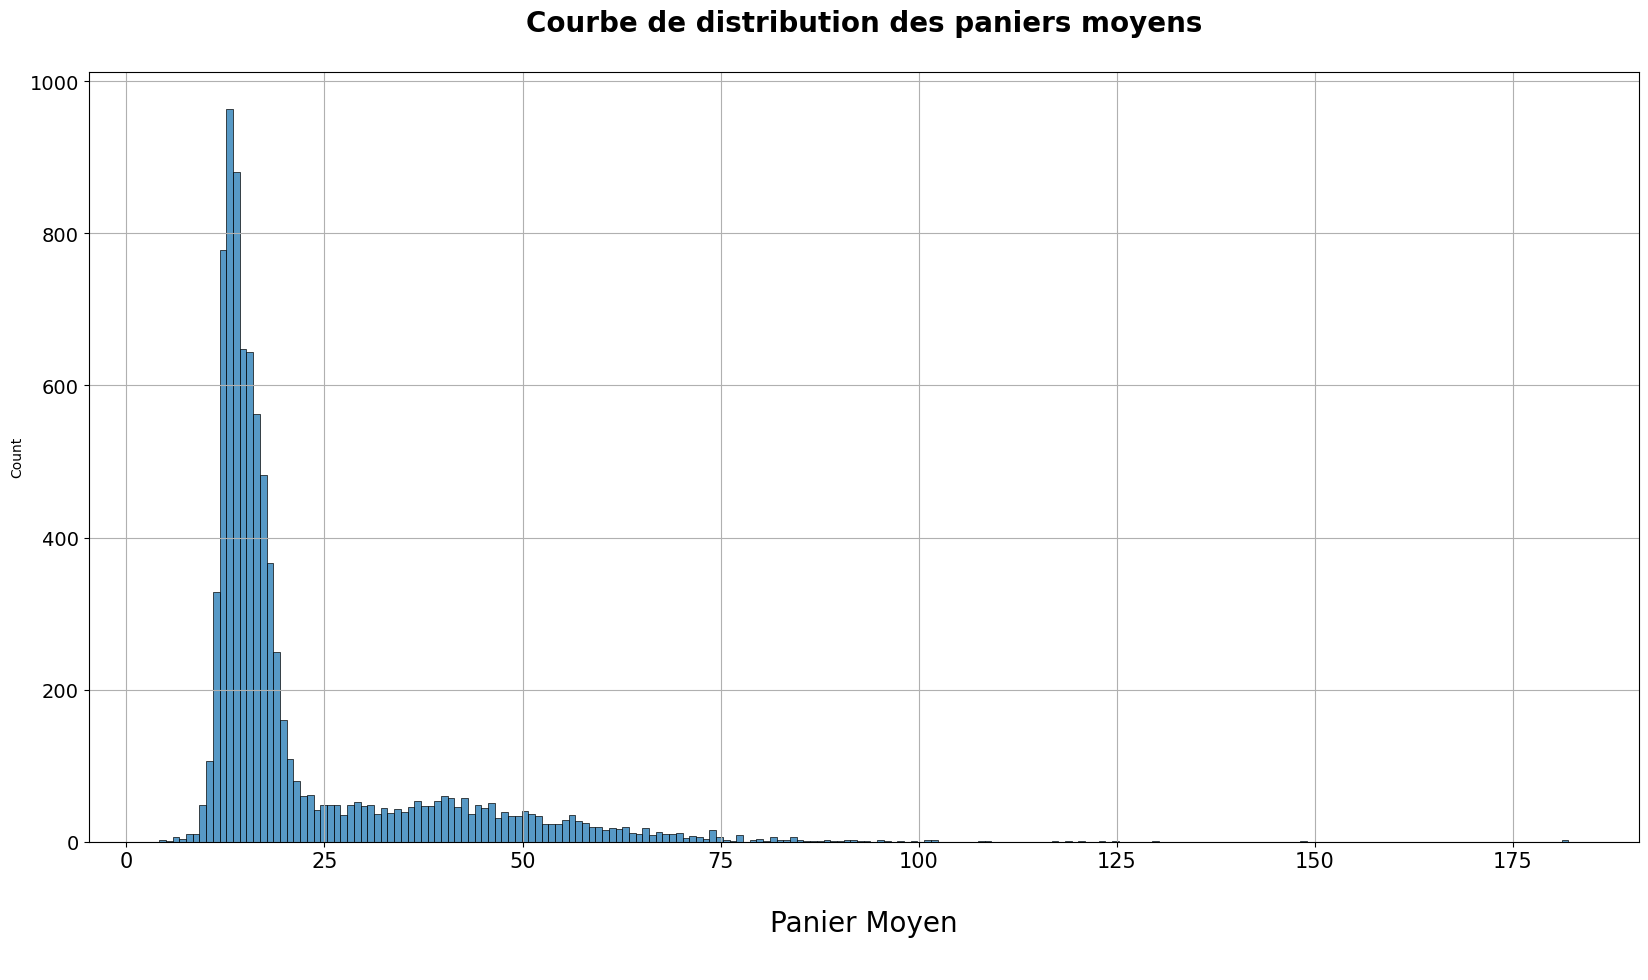

In [73]:
plt.figure(figsize=(20,10))
sns.histplot(data=panier_m, x="panier_moyen")
plt.xlabel("\n""Panier Moyen""\n", fontsize=20)
plt.title("Courbe de distribution des paniers moyens""\n", fontsize=20, fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()     

In [74]:
# Coefficient d'asymétrie du Chiffre d'affaires
print("coef d'asymétrie : ",panier_m["panier_moyen"].skew())

# Coef d'applatissement
print("Coef d'aplatissement :", panier_m["panier_moyen"].kurtosis())

coef d'asymétrie :  2.4019084395048473
Coef d'aplatissement : 8.147506952507536


In [75]:
# Test de normalité de Jarque-Bera

# H0 : La distribution de la fréquence suit une loi normale (p-value > 0.05)
# H1 : La distribution de la fréquence ne suit pas une loi normale (p-value < 0.05)

print(stats.jarque_bera(panier_m["panier_moyen"]))

SignificanceResult(statistic=32021.37008964555, pvalue=0.0)


La distribution ne suit pas de loi normale. Vérifions la Variance

In [76]:
# Création de liste
tranche_age1 = list(panier_m["tranche"].unique())

# Création de liste
pop_tas1 = list()

# Récupération des paniers moyens pour chaque tranche d'age
for ta in tranche_age1 :
    pop_ta1 = panier_m[panier_m["tranche"] == ta]["panier_moyen"]
    pop_tas1.append(pop_ta1)
pop_tas1

[0       29.062500
 1       22.428780
 2       41.654074
 3       45.420769
 4       59.312857
           ...    
 1142    22.456000
 1143    66.517500
 1144    21.163226
 1145    41.976111
 1146    39.357027
 Name: panier_moyen, Length: 1147, dtype: float64,
 1147    53.402069
 1148    51.378125
 1149    45.496170
 1150    94.978000
 1151    35.194848
           ...    
 2703    12.667241
 2704    14.438857
 2705    13.462703
 2706    13.551111
 2707    13.662692
 Name: panier_moyen, Length: 1561, dtype: float64,
 2708    13.196434
 2709    12.997468
 2710    12.779730
 2711    14.421875
 2712    12.073744
           ...    
 4483    13.763711
 4484    12.709573
 4485    13.382192
 4486    14.925042
 4487    13.940882
 Name: panier_moyen, Length: 1780, dtype: float64,
 4488    12.475455
 4489    13.016520
 4490    12.077391
 4491    16.856271
 4492    14.247634
           ...    
 6093    17.292535
 6094    15.275294
 6095    16.185135
 6096    20.185000
 6097    15.768333
 Name: pani

In [77]:
# Comparaison de la variance des paniers moyens entre chaque tranche d'age : Test de Levene

# H0 : Il n'y a aucune différence significative entre les variances (p-value > 0.05)
# H1 : Il y a une différence significative entre les variances (p-value < 0.05)

stats.levene(*pop_tas1)

LeveneResult(statistic=1394.241068985106, pvalue=0.0)

Nous pouvons constater que les variances sont significativement différentes. De ce fait nous ne pouvons pas réaliser le test paramétrique d'ANOVA. Nous utiliserons dans ce cas le test non paramétrique de Kruskal-Wallis.

In [78]:
# Test de Kruskal-Wallis

# H0 : La différence entre les médianes n'est pas significatives (p-value > 0.05)
# H1 : La différence entre les médianes est significatives (p-value < 0.05)

# Création d'une boucle permettant de faire les différentes comparaisons de la p-value entre les tranches d'age
E = dict()
for ta in tranche_age1 :
    pop_ta1 = panier_m[panier_m["tranche"] == ta]["panier_moyen"]
    for ta_2 in tranche_age1 :
      if ta < ta_2 :
            pop_ta_2 = panier_m[panier_m["tranche"] == ta_2]["panier_moyen"]
            _, p = stats.kruskal(pop_ta1, pop_ta_2)
            E[(ta, ta_2)] = p
E

{('18-24', '25-34'): 5.227105240157538e-32,
 ('18-24', '35-44'): 0.0,
 ('18-24', '45-54'): 0.0,
 ('18-24', '55-64'): 0.0,
 ('18-24', '65<'): 0.0,
 ('25-34', '35-44'): 2.3639645802007632e-272,
 ('25-34', '45-54'): 3.4877005500236134e-215,
 ('25-34', '55-64'): 1.7193043553917495e-98,
 ('25-34', '65<'): 3.4911198818747907e-99,
 ('35-44', '45-54'): 2.5153419168244587e-22,
 ('35-44', '55-64'): 1.6969046154796726e-259,
 ('35-44', '65<'): 1.7501501240909064e-265,
 ('45-54', '55-64'): 3.3466097297922553e-130,
 ('45-54', '65<'): 1.0772433236629267e-134,
 ('55-64', '65<'): 0.6751390723622609}

<Figure size 640x480 with 0 Axes>

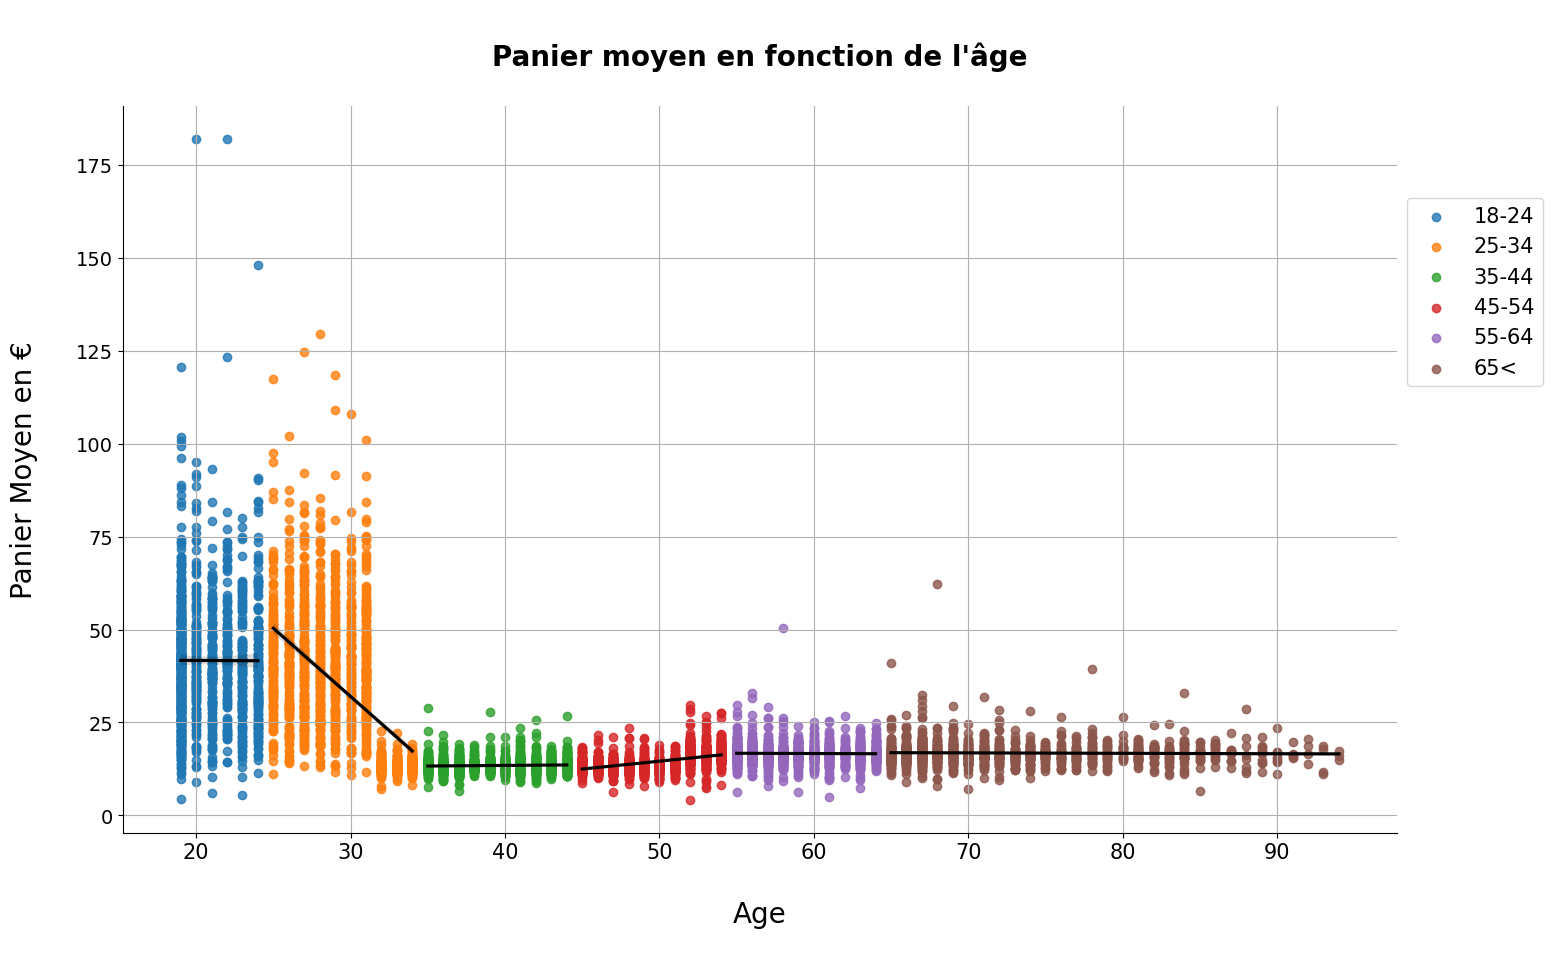

In [79]:
plt.figure()
sns.lmplot(
    data=panier_m,
    x="age",
    y="panier_moyen",
    hue="tranche",
    height=8,
    aspect=1.7,
    line_kws={"color": "black"},
    legend = False)
plt.title("\n""Panier moyen en fonction de l'âge""\n", fontsize=20, fontweight="bold")
plt.xlabel("\n""Age""\n", fontsize=20)
plt.ylabel("Panier Moyen en €""\n", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.6), fontsize=15)
plt.grid(True)
plt.show()

## 3.5 : La catégorie de livre acheté par rapport à l'age <a class="anchor" id="section_3_5"></a>

In [80]:
# Création de la colonne tranche dans la table all_data
all_data["tranche"], bin_values = pd.cut(
    x=all_data["age"],
    bins=[18, 24, 34, 44, 54, 64, 100],
    labels=bin_labels,
    retbins=True,
)
all_data.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ,mois,année,age,tranche
0,0_1259,2021-03-01 00:01:07,s_1,c_329,f,1967,11.99,0,3,2021,56,55-64
1,0_1390,2021-03-01 00:02:26,s_2,c_664,m,1960,19.37,0,3,2021,63,55-64
2,0_1352,2021-03-01 00:02:38,s_3,c_580,m,1988,4.50,0,3,2021,35,35-44
3,0_1458,2021-03-01 00:04:54,s_4,c_7912,f,1989,6.55,0,3,2021,34,25-34
4,0_1358,2021-03-01 00:05:18,s_5,c_2033,f,1956,16.49,0,3,2021,67,65<


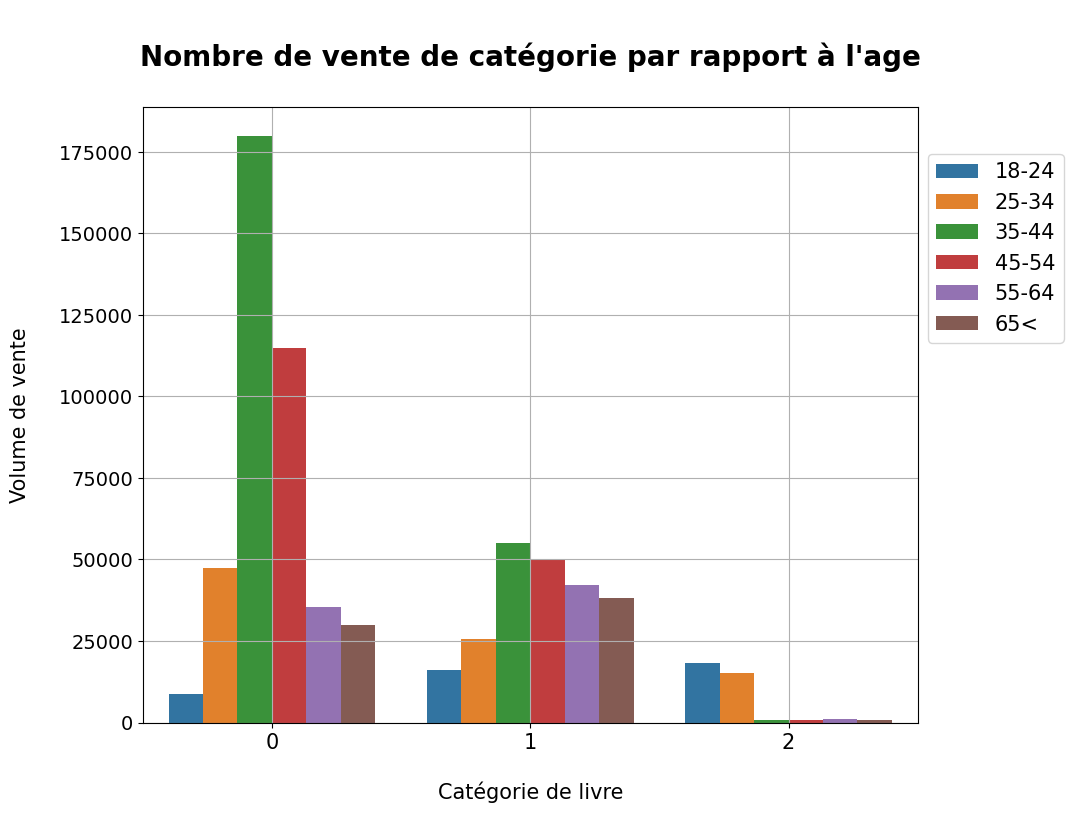

In [81]:
plt.figure(figsize=(10,8))
sns.countplot(x="categ", hue="tranche", data=all_data)
plt.title("\n""Nombre de vente de catégorie par rapport à l'age""\n", fontsize=20, fontweight="bold")
plt.xlabel("\n""Catégorie de livre""\n", fontsize=15)
plt.ylabel("Volume de vente""\n", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.6), fontsize=15)
plt.grid(True)
plt.show()

Nous pouvons constater que la catégorie 0 est très populaire auprès de 35-44 ans suivi de près par les 45-54 ans.  
La catégorie 1 rencontre le même succès auprès des 35-44 et 45-54 mais la quantité de livre vendu est moins importante que la catégorie 0.  
Enfin, la catégorie 2 ne recontre pas grand succès et touche essentiellement les 18-24 et 25-35

In [82]:
# Tableau de contingeance
cont_categ_age = pd.crosstab(all_data["categ"], all_data["tranche"], margins=True, margins_name="Total")
cont_categ_age

tranche,18-24,25-34,35-44,45-54,55-64,65<,Total
categ,,,,,,,
0,8600,47213,179833,114655,35417,29741,415459
1,16110,25577,55125,50124,42070,38163,227169
2,18300,15103,815,679,958,628,36483
Total,43010,87893,235773,165458,78445,68532,679111


In [83]:
# Test de Chi2

# H0 : Les ventes par catégories sont indépendantes de l'age (p-value > 0.05)
# H1 : Les ventes par catégories et l'age sont dépendantes l'un de l'autre (p-value < 0.05)

c, p, dof, expected = stats.chi2_contingency(cont_categ_age)
print(p)
print(c)

0.0
215339.986282719


La p-value étant de 0, nous pouvons rejeter l'hypothèse nulle et ainsi dire que les ventes par catégories sont dépandantes de l'age.

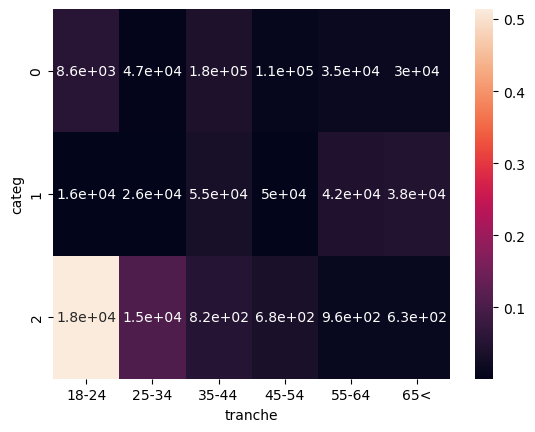

In [84]:
tx = cont_categ_age.loc[:,["Total"]]
ty = cont_categ_age.loc[["Total"], :]
n = len(all_data)
indep = tx.dot(ty) / n

c= cont_categ_age.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()

Sur le Heatmap du tableau de contingence, nous pouvons constater que la catégorie 2 joue un role important dans la dépendance des deux variables notamment les 18-24 mais aussi les 25-34.